# Density-based


## HF standartized

## EPS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [2]:
data: pd.DataFrame = pd.read_csv('../../datasets/hf_scaled/HF_standardized.csv')
data.pop('DEATH_EVENT') #Remove target variable

EPS = [0.1, 0.2, 0.35, 0.5, 0.6, 0.75, 0.8, 0.9, 1, 1.5, 2.5]
rows, cols = ds.choose_grid(len(EPS))

In [3]:
data.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking
0,1.192945,0.000166,-1.530560,1.681648e-02,0.490057,-1.504036,-1.629502,0,0,1,1,0
1,-0.491279,7.514640,-0.007077,7.535660e-09,-0.284552,-0.141976,-1.603691,0,0,0,1,0
2,0.350833,-0.449939,-1.530560,-1.038073e+00,-0.090900,-1.731046,-1.590785,0,0,0,1,1
3,-0.912335,-0.486071,-1.530560,-5.464741e-01,0.490057,0.085034,-1.590785,1,0,0,1,0
4,0.350833,-0.435486,-1.530560,6.517986e-01,1.264666,-4.682176,-1.577879,1,1,0,0,0


EPS - 0.75
EPS - 0.8
EPS - 0.9
EPS - 1
EPS - 1.5
EPS - 2.5


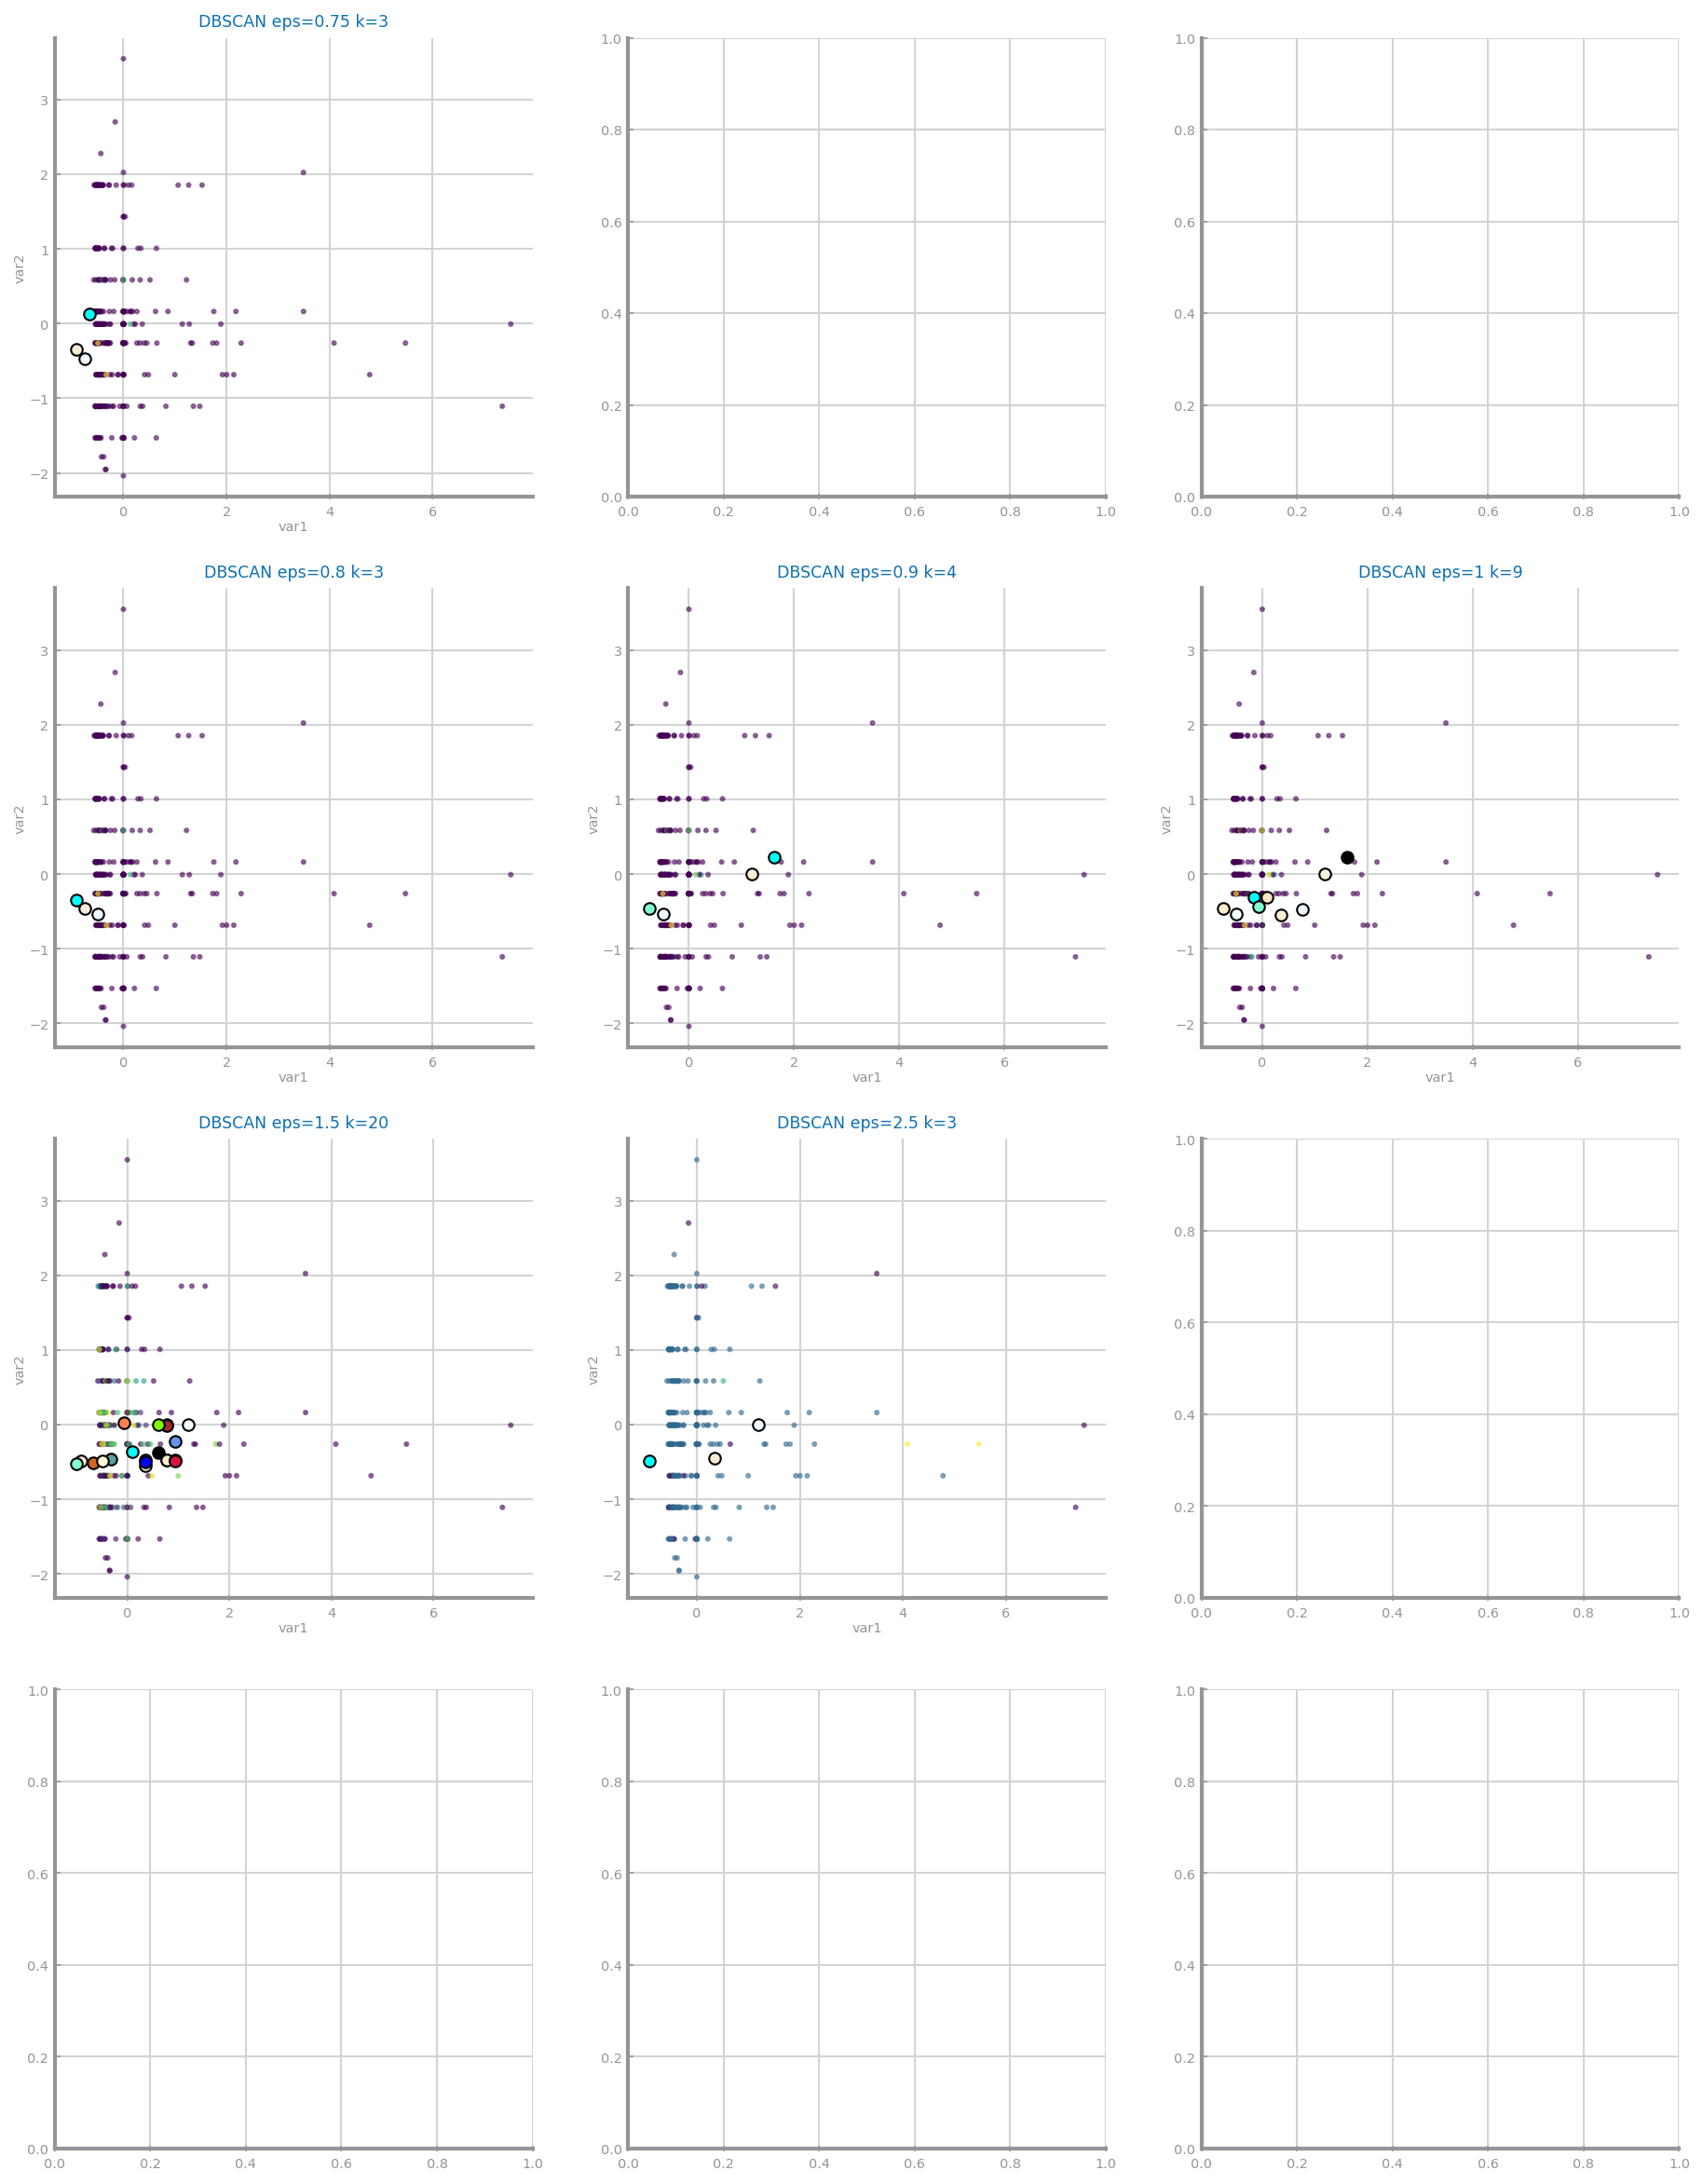

In [4]:
mse: list = []
sc: list = []
db: list = []

_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(EPS)):
    estimator = DBSCAN(eps=EPS[n], min_samples=2)
    estimator.fit(data)
    labels = estimator.labels_
    k = len(set(labels)) - (1 if -1 in labels else 0)
    if k > 1:
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        db.append(davies_bouldin_score(data, labels))
        
        print("EPS - " + str(EPS[n]))


        ds.plot_clusters(data, 1, 2, labels.astype(float), estimator.components_, k,
                         f'DBSCAN eps={EPS[n]} k={k}', ax=axs[i,j])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    else:
        mse.append(0)
        sc.append(0)
        db.append(0)
plt.show()

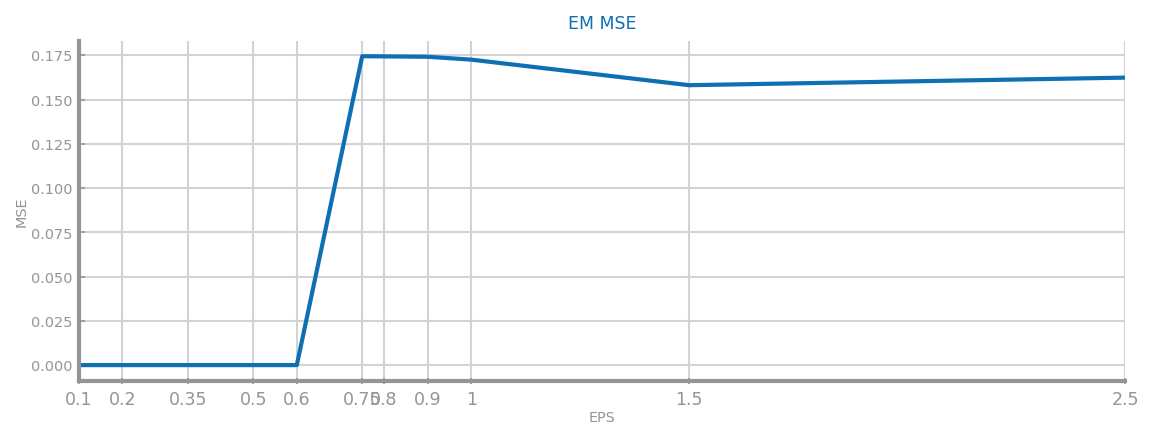

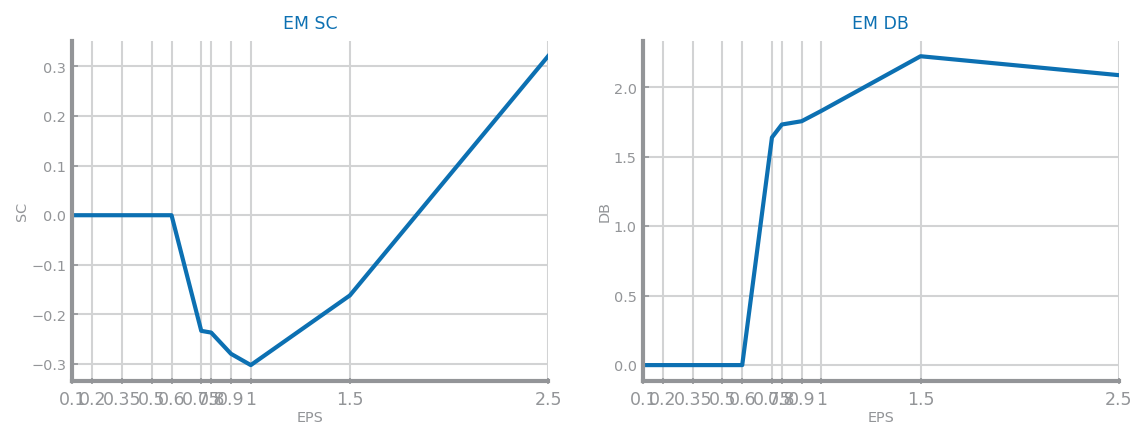

In [5]:
fig = plt.figure(figsize=(9,3))
ds.plot_line(EPS, mse, title='EM MSE', xlabel='EPS', ylabel='MSE')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(9, 3), squeeze=False)
ds.plot_line(EPS, sc, title='EM SC', xlabel='EPS', ylabel='SC', ax=ax[0, 0])
ds.plot_line(EPS, db, title='EM DB', xlabel='EPS', ylabel='DB', ax=ax[0, 1])
plt.show()

## Stuff for gower metric

Code comes from:
- https://sourceforge.net/projects/gower-distance-4python/files/gower_pdist.ipynb/download

Is based on the worki being done in here:
- https://github.com/scikit-learn/scikit-learn/issues/5884

In [6]:
import numbers
from sklearn.preprocessing import scale
import numpy as np

#Normalize the array
def normalize_mixed_data_columns(arr, dtypes):
  
    if isinstance(arr,pd.DataFrame):
       arr =np.asmatrix(arr.copy())
    elif isinstance(arr,np.ndarray):
       arr =arr.copy()
    else:
       raise ValueError('A DataFrame or ndarray must be provided.')
    rows,cols = arr.shape
    for col in range(cols):
        if np.issubdtype(dtypes[col],np.number):
            max = arr[:,col].max()+0.0  #Converts it to double
            if (cols>1):
                arr[:,col] /= max
            else:    
                arr= arr/max
    return( arr)

#This is to obtain the range (max-min) values of each numeric column
def calc_range_mixed_data_columns(arr, dtypes):
    rows,cols = arr.shape
    
    result = np.zeros(cols)
    for col in range(cols):
        if np.issubdtype(dtypes[col],np.number):
            result[col]= arr[:,col].max()-arr[:,col].min()
    return( result)
    


In [7]:
#This function must be refactored on pdist module to support mixed data
def _copy_array_if_base_present(a):
    if a.base is not None:
        return a.copy()
    elif np.issubsctype(a, np.float32):
        return np.array(a, dtype=np.double)
    else:
        return a

#This function must be refactored on pdist module to support mixed data
def _convert_to_double(X):
    if X.dtype == np.object:
        return X.copy()
    if X.dtype != np.double:
        X = X.astype(np.double)
    if not X.flags.contiguous:
        X = X.copy()
    return X

#This function was copied from pdist because it is private. No change in the original function.
def _validate_vector(u, dtype=None):
    # XXX Is order='c' really necessary?
    u = np.asarray(u, dtype=dtype, order='c').squeeze()
    # Ensure values such as u=1 and u=[1] still return 1-D arrays.
    u = np.atleast_1d(u)
    if u.ndim > 1:
        raise ValueError("Input vector should be 1-D.")
    return u


#An excerpt from pdist function only with the basic structure to call the gower dist. 
#The original pdist must be adapted for Gower using this as example.
def pdist_(X, metric='euclidean', p=2, w=None, V=None, VI=None):
    X = np.asarray(X, order='c')

    # The C code doesn't do striding.
    X = _copy_array_if_base_present(X)

    s = X.shape
    if len(s) != 2:
        raise ValueError('A 2-dimensional array must be passed.')

    m, n = s
    dm = np.zeros((m * (m - 1)) // 2, dtype=np.double)

    #(...)
    dfun = metric
    k = 0
    for i in range(0, m - 1):
        for j in range(i + 1, m):
            dm[k] = dfun(X[i], X[j],V=V,w=w,VI=VI)
            k = k + 1

    return dm



In [8]:
from scipy.spatial.distance import pdist, squareform
import numbers

#It's necessary to obtain the columns dtypes
dtypes = data.dtypes

#It's necessary to normalize between 0 and 1
Xn=normalize_mixed_data_columns(data,dtypes)

#It's necessary to obtain the range (max-min) values of each numeric column
ranges=calc_range_mixed_data_columns(Xn,dtypes)





def gower(xi, xj,V=ranges,w=None,VI=dtypes):
    cols = len(xj)
    
    xi=_validate_vector(xi)
    xj=_validate_vector(xj)

    if V is None:
        raise ValueError('An array with the (max-min) ranges for each numeric column must be passed in V.')

    if VI is None:
        raise ValueError('An array with the dtypes or each numeric column must be passed in VI.')

    if w is None:
        w=[1]*cols
    
    sum_sij =0.0
    sum_wij =0.0
    for col in range(cols):
        sij=0.0
        wij=0.0
        
        if np.issubdtype(VI[col], np.number):
            sij=abs(xi[col]-xj[col])/(V[col])
            wij=(w[col],0)[pd.isnull(xi[col]) or pd.isnull(xj[col])]
            
        else:
            sij=(1,0)[xi[col]==xj[col]]
            wij=(w[col],0)[pd.isnull(xi[col]) and pd.isnull(xj[col])]
        
        sum_sij+= (wij*sij)
        sum_wij+=wij

    
    return(sum_sij/sum_wij)




### A small test They also had
Just to check if it was working

In [9]:
print("Dissimilarities :")
D=np.tril(squareform(pdist_(Xn, gower,V=ranges,VI=dtypes)))
print(D)
#To get the similarities, do 1-D

Dissimilarities :
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.23628905 0.         0.         ... 0.         0.         0.        ]
 [0.20574763 0.23231303 0.         ... 0.         0.         0.        ]
 ...
 [0.52046596 0.4078607  0.51622857 ... 0.         0.         0.        ]
 [0.37728511 0.26245992 0.18744312 ... 0.35331932 0.         0.        ]
 [0.35377599 0.28196212 0.18028204 ... 0.34571635 0.07862517 0.        ]]


## Trying different distance metrics

In [10]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard', 'hamming', 'gower']
distances = []
for m in METRICS:
    if m == "gower":
        #Add gower
        dist = np.mean(np.mean(squareform(pdist_(Xn, gower,V=ranges,VI=dtypes))))
        distances.append(dist)
        pass
    else:
        dist = np.mean(np.mean(squareform(pdist(data.values, metric=m))))
        distances.append(dist)

print('AVG distances among records', distances)
distances[0] *= 0.6
distances[1] *= 0.4
distances[2] *= 0.6
distances[3] *= 0.1
distances[4] *= 0.1
distances[5] *= 1
distances[5] *= 0.5

print('CHOSEN EPS', distances)


AVG distances among records [3.797073391321629, 9.281843633694901, 2.53977150834137, 0.860282892396361, 0.8663685764092921, 0.7456702572305307, 0.292988347713976]
CHOSEN EPS [2.2782440347929773, 3.7127374534779607, 1.5238629050048218, 0.08602828923963611, 0.08663685764092921, 0.37283512861526535, 0.292988347713976]


metric euclidean
labels:  [ 0 -1  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0
  0  0  0  0  1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
 -1  0  0  0 -1  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0
  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  3  0 -1  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0
  0  0  0  0  0  0 -1  0  0  0  0  1  0  0  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0]
We got k=4
metric cityblock
labels:  [ 0 -1  1  0 -1 -1 -1 -1 -

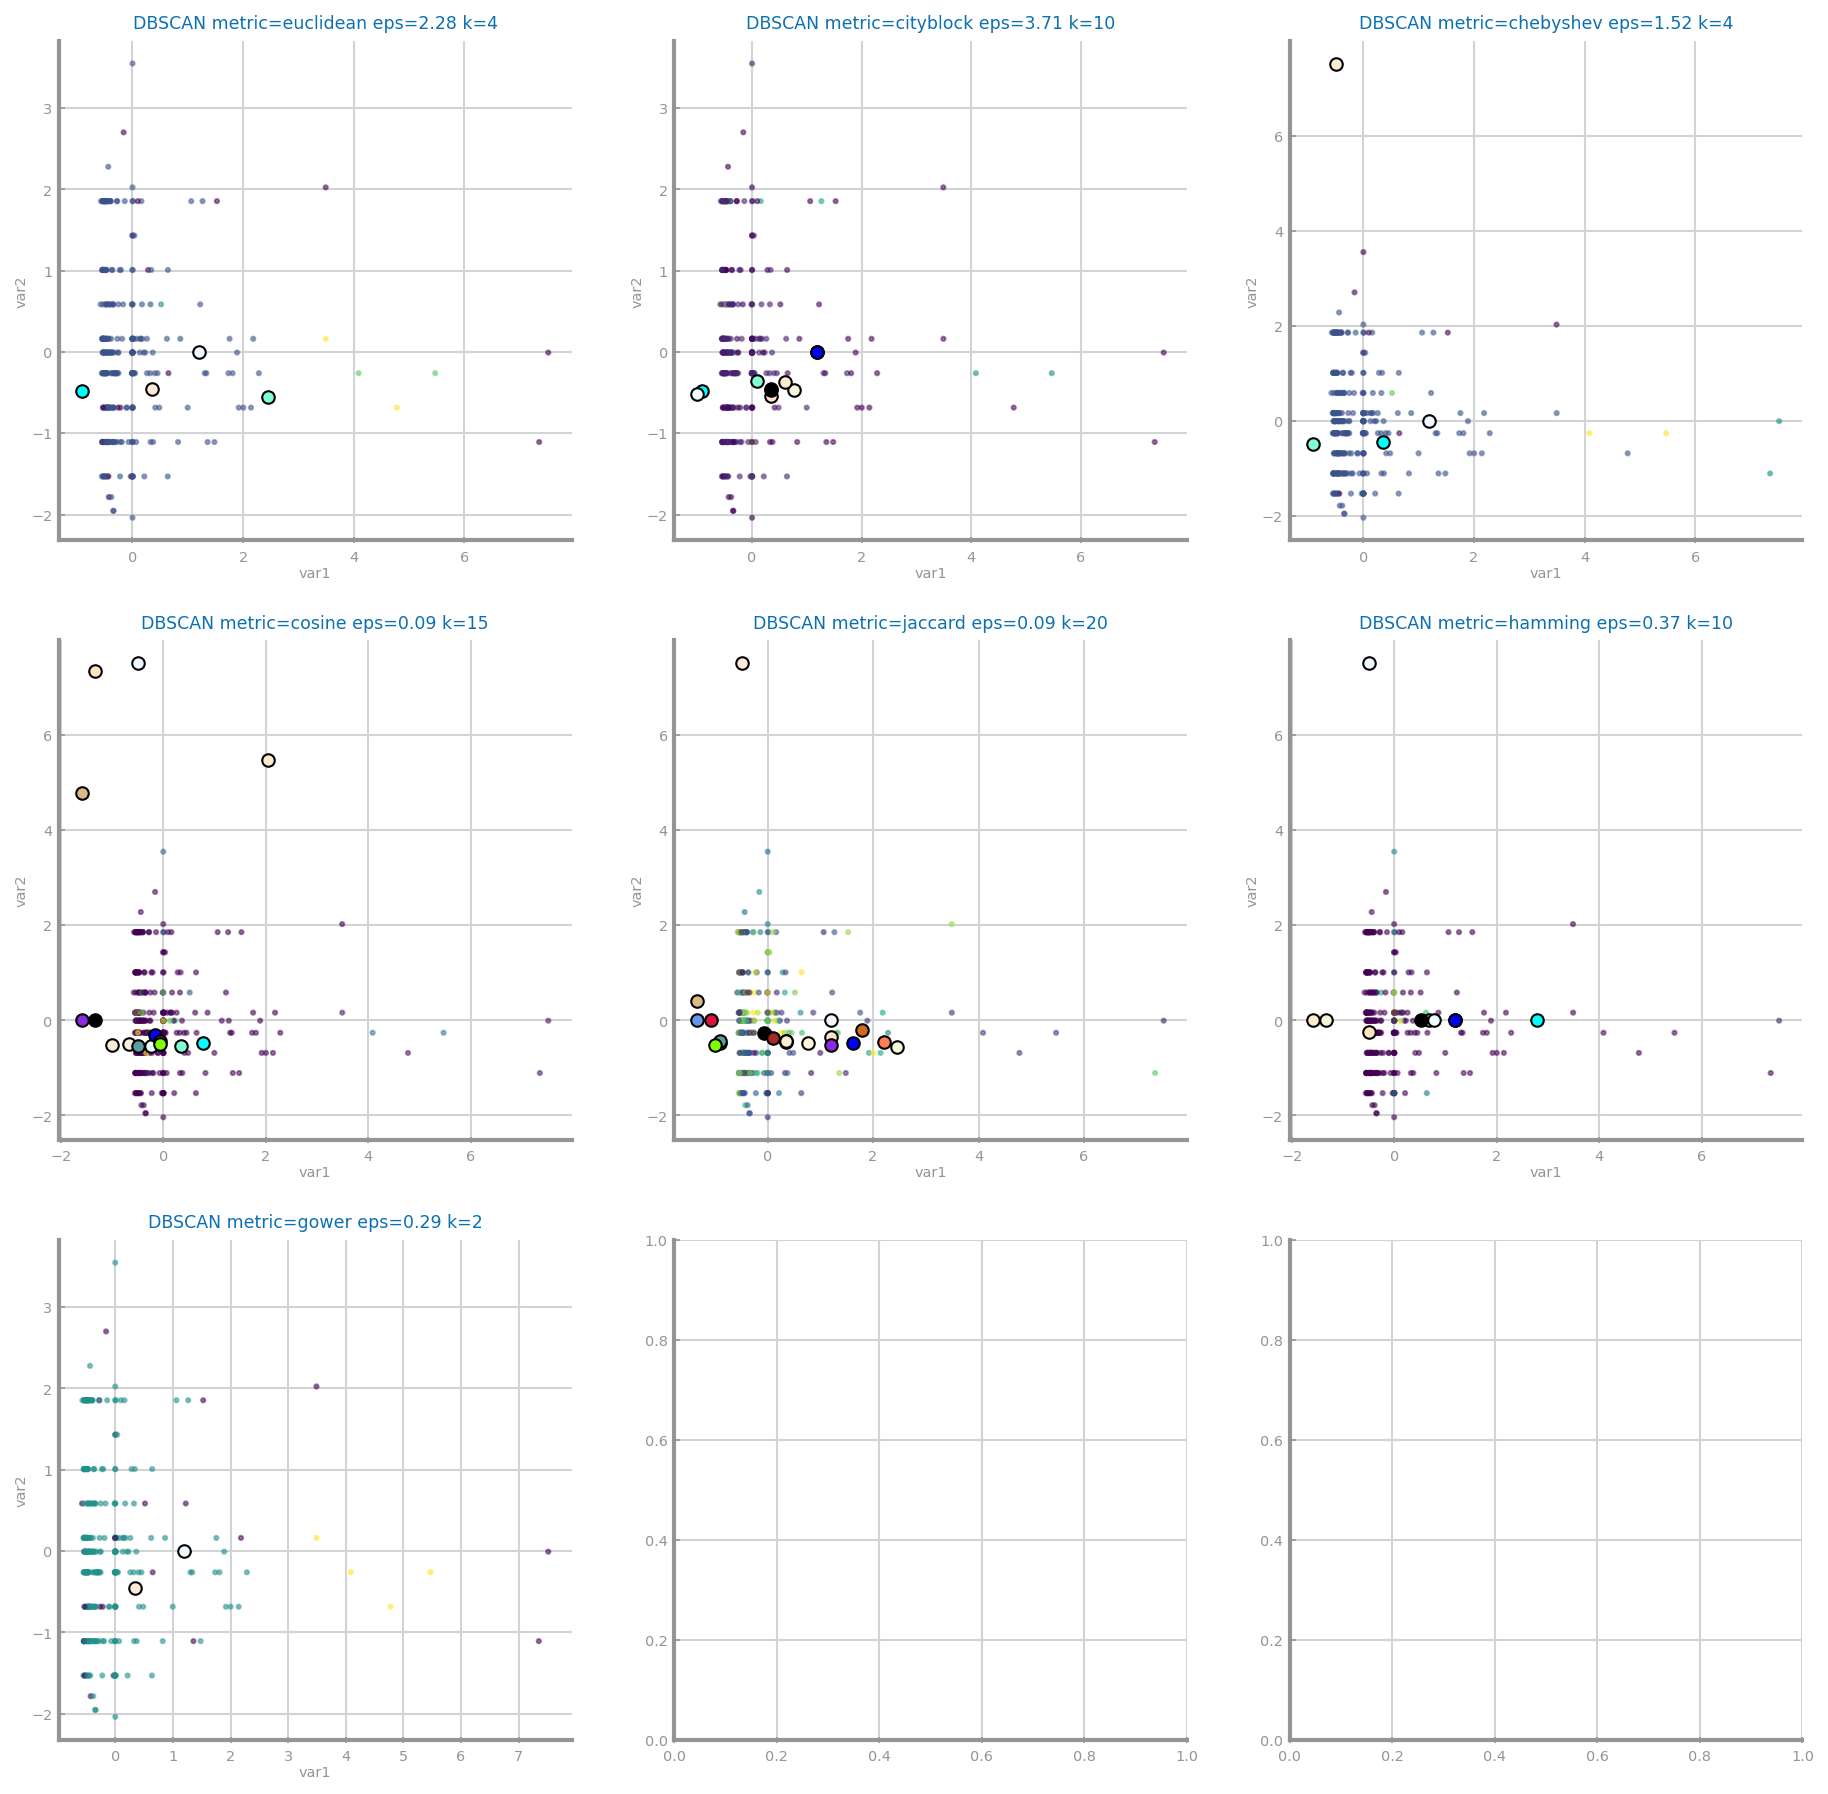

In [11]:
mse: list = []
sc: list = []
db: list = []

rows, cols = ds.choose_grid(len(METRICS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(METRICS)):
    if METRICS[n] == "gower":
        estimator = DBSCAN(eps=distances[n], min_samples=2, metric=gower)
    else:
        estimator = DBSCAN(eps=distances[n], min_samples=2, metric=METRICS[n])
    print("metric {}".format(METRICS[n]))
    estimator.fit(data)
    labels = estimator.labels_
    print("labels: ", labels)
    k = len(set(labels)) - (1 if -1 in labels else 0)
    print("We got k={}".format(k))
    if k > 1:
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        db.append(davies_bouldin_score(data, labels))

        
        ds.plot_clusters(data, 1, 2, labels.astype(float), estimator.components_, k,
                         f'DBSCAN metric={METRICS[n]} eps={distances[n]:.2f} k={k}', ax=axs[i,j])
    else:
        mse.append(0)
        sc.append(0)
        db.append(0)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

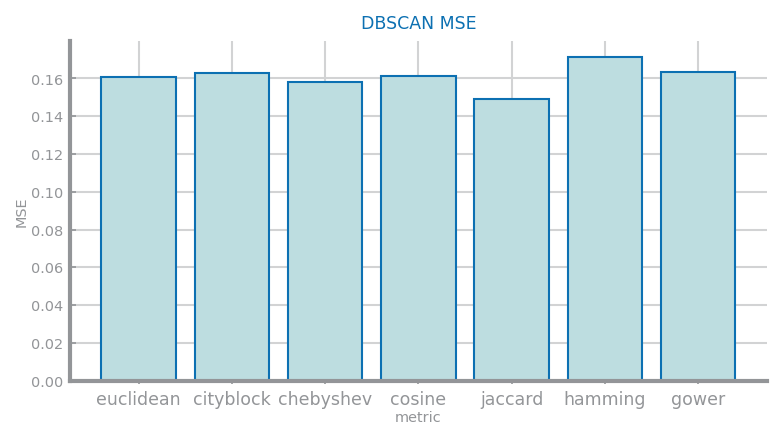

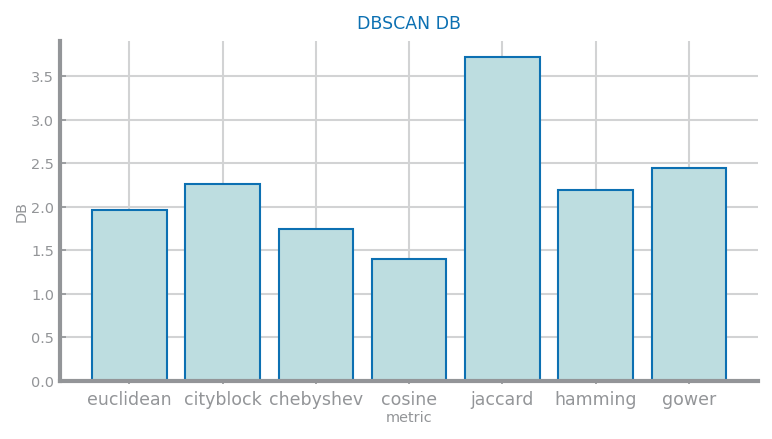

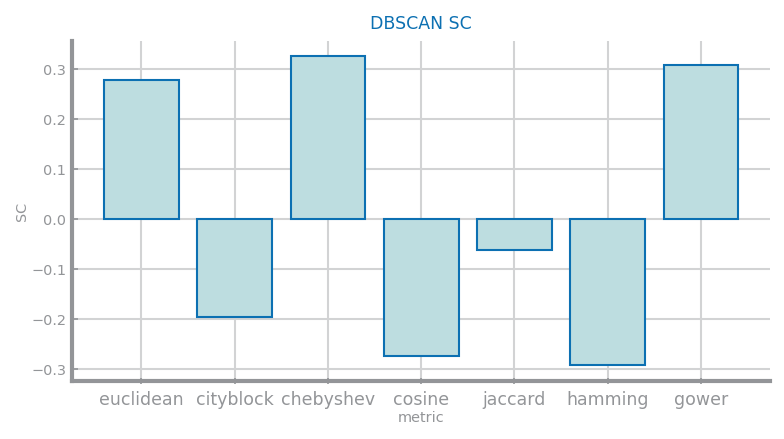

[0.27738586120828806, -0.19481997492693867, 0.3248518844125939, -0.273098641634938, -0.06118421030506261, -0.29171452115431395, 0.30701766437122224]


In [12]:
fig = plt.figure(figsize=(6,3))
ds.bar_chart(METRICS, mse, title='DBSCAN MSE', xlabel='metric', ylabel='MSE')
plt.show()

fig = plt.figure(figsize=(6,3))
ds.bar_chart(METRICS, db, title='DBSCAN DB', xlabel='metric', ylabel='DB')
plt.show()

fig = plt.figure(figsize=(6,3))
ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC')
plt.show()
print(sc)


#fig, ax = plt.subplots(1, 2, figsize=(8, 3), squeeze=False)
#ds.bar_chart(METRICS, db, title='DBSCAN DB', xlabel='metric', ylabel='DB', ax=ax[0, 0])
#ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], percentage=True)
#plt.show()

## Heart Failure Prediction Dataset - Standardized + Importance + FG + Outlier

In [13]:
data: pd.DataFrame = pd.read_csv('../../datasets/TO_TEST/HF/HR_S_FImp_extra_outlierTrim_IQS.csv')
data.pop('DEATH_EVENT') #Remove target variable

EPS = [0.1, 0.2, 0.35, 0.5, 0.6, 0.75, 0.8, 0.9, 1, 1.5, 2.5]
rows, cols = ds.choose_grid(len(EPS))

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -

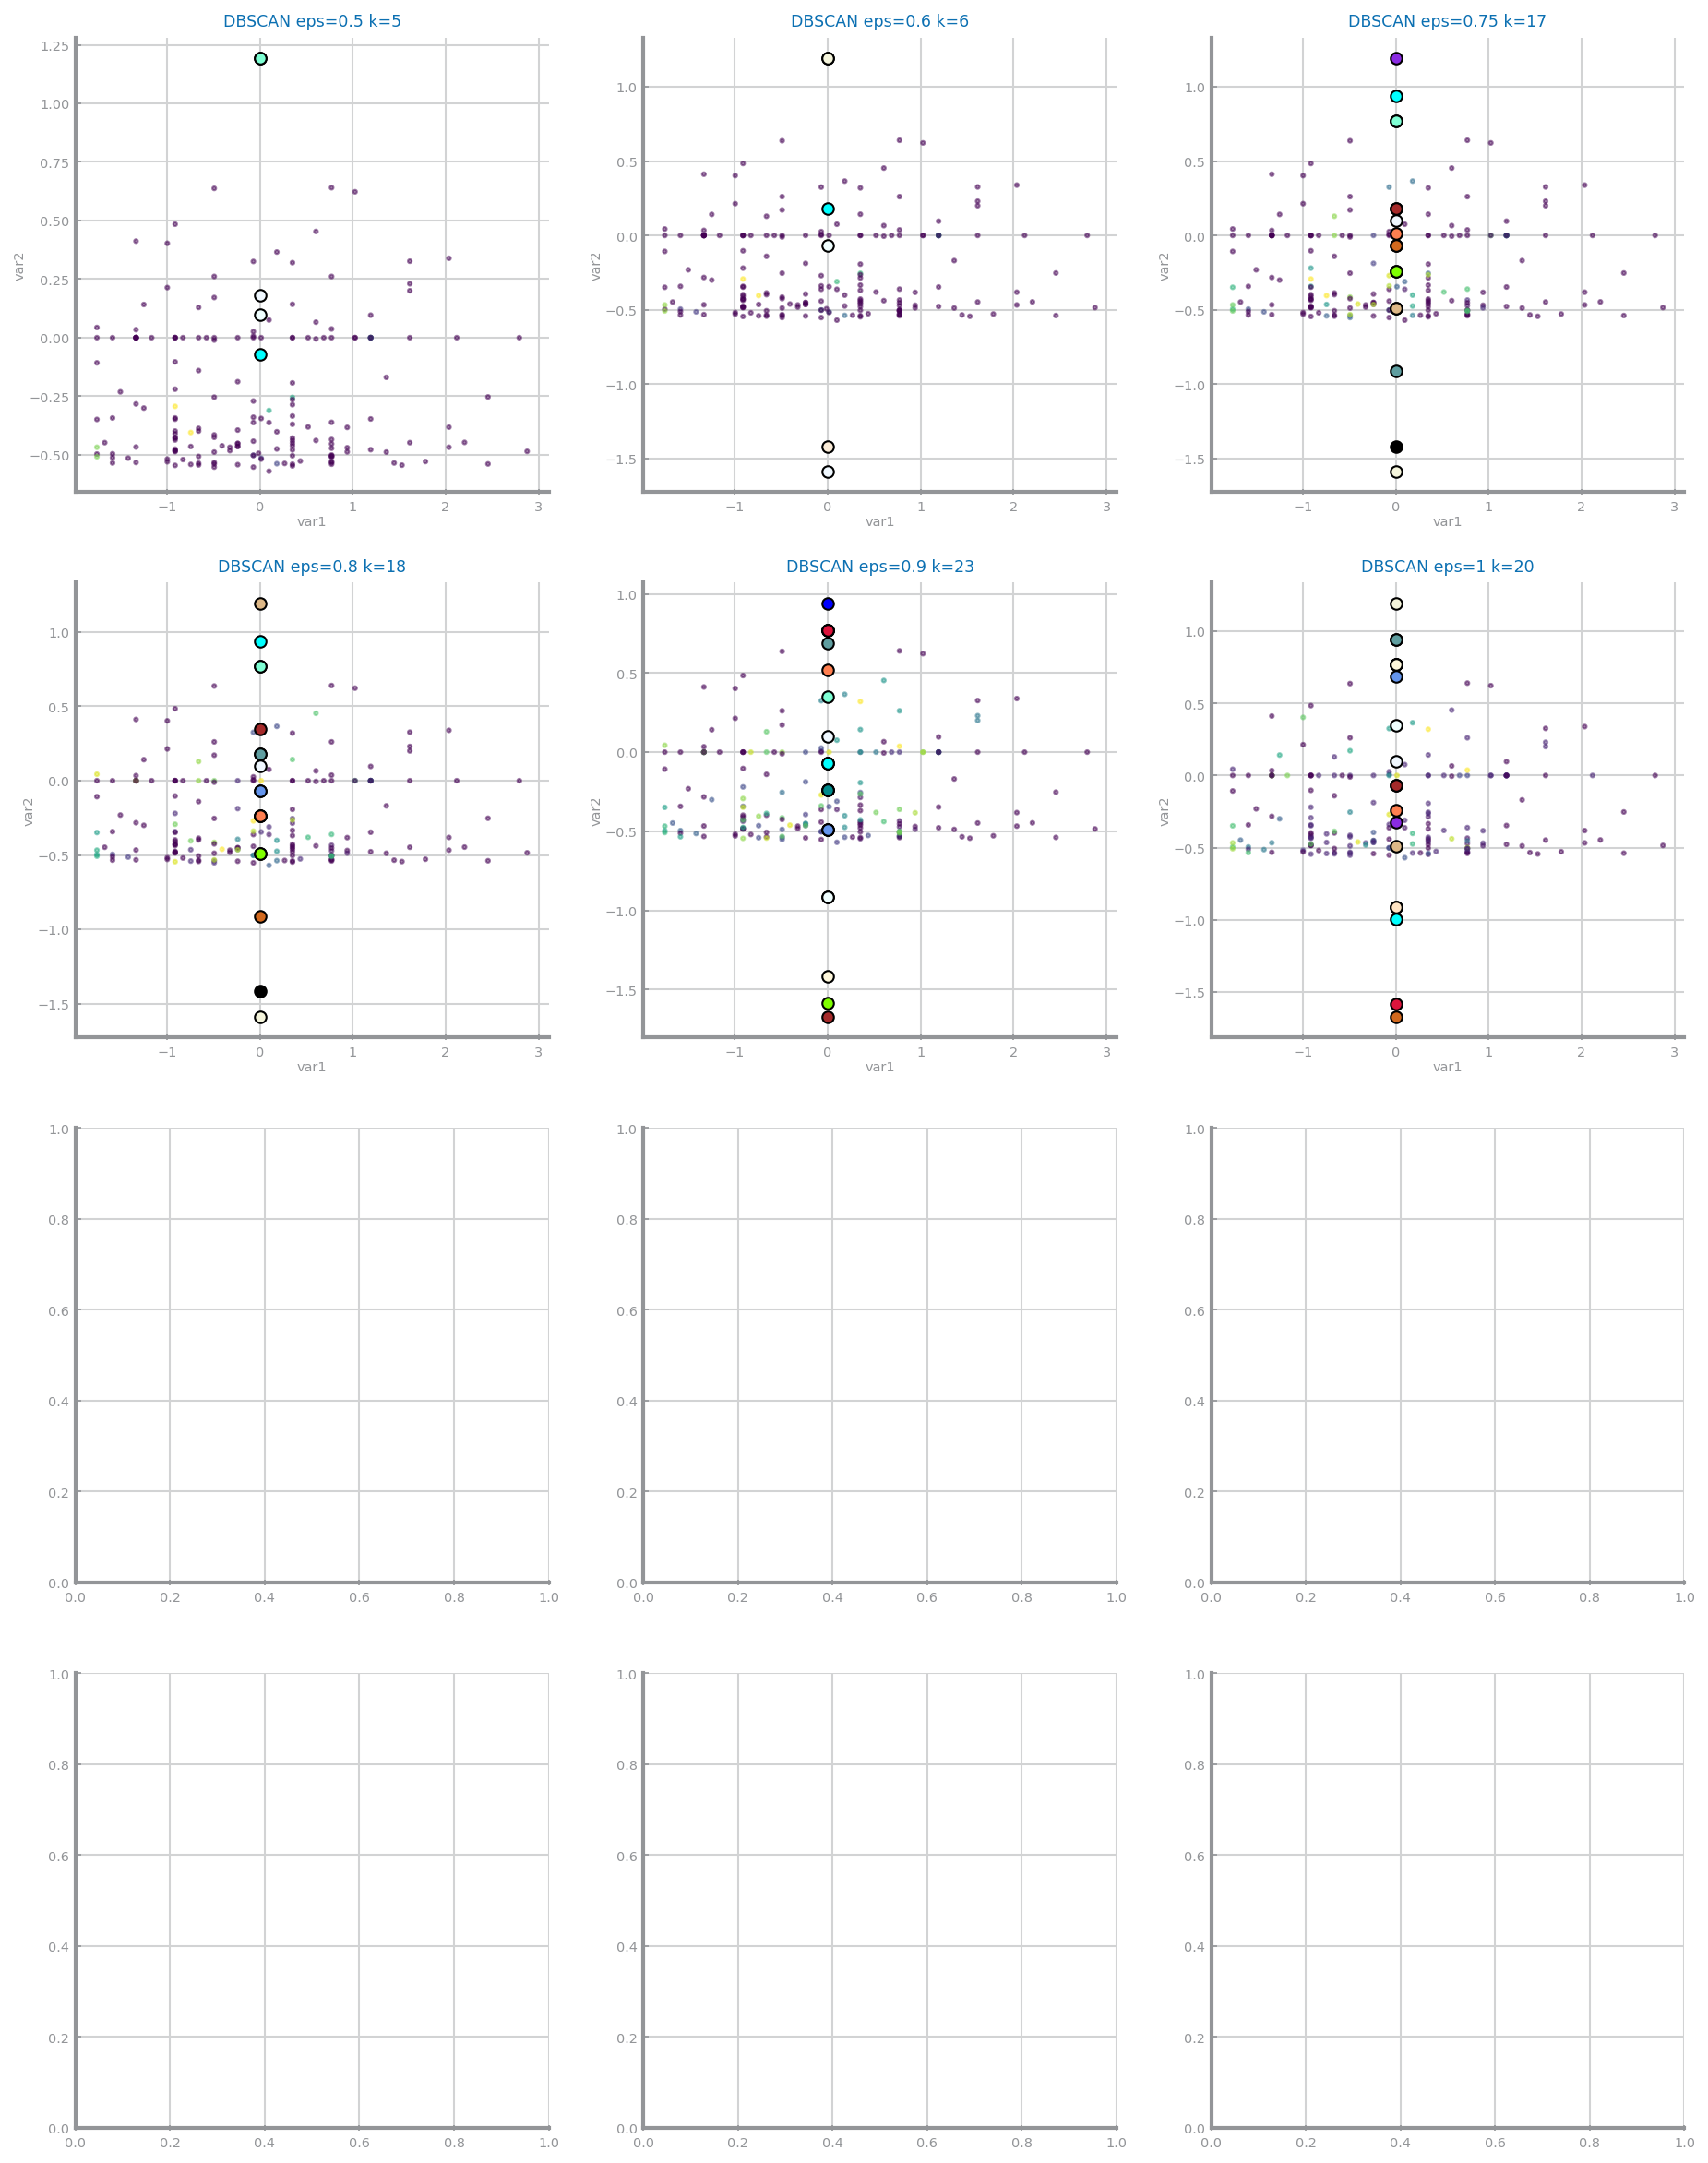

In [14]:
mse: list = []
sc: list = []
db: list = []

_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(EPS)):
    estimator = DBSCAN(eps=EPS[n], min_samples=2)
    estimator.fit(data)
    labels = estimator.labels_
    print(labels)
    k = len(set(labels)) - (1 if -1 in labels else 0)
    if k > 1:
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        db.append(davies_bouldin_score(data, labels))
        
        print("EPS - " + str(EPS[n]))


        ds.plot_clusters(data, 1, 2, labels.astype(float), estimator.components_, k,
                         f'DBSCAN eps={EPS[n]} k={k}', ax=axs[i,j])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    else:
        mse.append(0)
        sc.append(0)
        db.append(0)
plt.show()

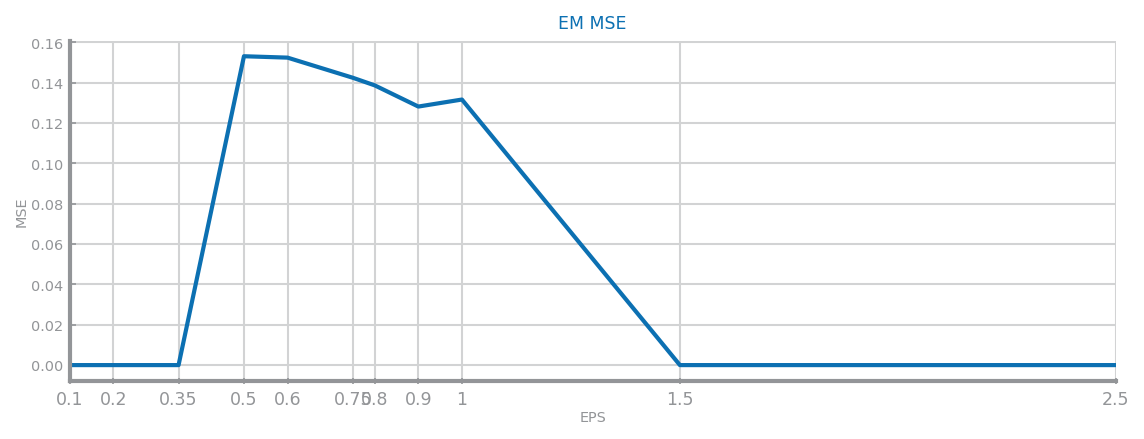

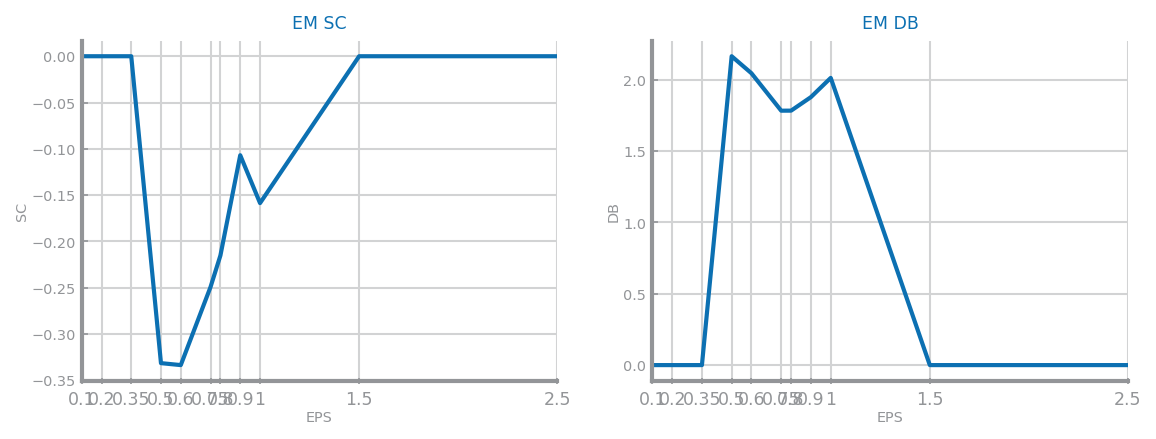

In [15]:
fig = plt.figure(figsize=(9,3))
ds.plot_line(EPS, mse, title='EM MSE', xlabel='EPS', ylabel='MSE')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(9, 3), squeeze=False)
ds.plot_line(EPS, sc, title='EM SC', xlabel='EPS', ylabel='SC', ax=ax[0, 0])
ds.plot_line(EPS, db, title='EM DB', xlabel='EPS', ylabel='DB', ax=ax[0, 1])
plt.show()

#### For gower

In [16]:
#It's necessary to obtain the columns dtypes
dtypes = data.dtypes

#It's necessary to normalize between 0 and 1
Xn=normalize_mixed_data_columns(data,dtypes)
print(Xn)
#It's necessary to obtain the range (max-min) values of each numeric column
ranges=calc_range_mixed_data_columns(Xn,dtypes)

[[            nan  4.14624558e-01  2.58860582e-04 ...  7.16762184e-01
  -5.82475742e-01 -8.15959539e-01]
 [            nan  1.21936837e-01 -7.02784908e-01 ... -1.32951262e-01
  -6.70391061e-01 -7.96572071e-01]
 [            nan -3.17094744e-01 -7.59221908e-01 ...  7.16762184e-01
   3.29314907e-02 -7.96572071e-01]
 ...
 [            nan -2.44070235e-02 -4.22212395e-01 ...  8.66764553e-03
   2.08762129e-01  8.25512784e-01]
 [            nan -2.58557200e-01 -6.31835537e-01 ... -5.57807986e-01
   2.96677448e-01  8.25512784e-01]
 [            nan -3.17094744e-01 -6.22160623e-01 ...  2.91905461e-01
  -5.49838283e-02  1.00000000e+00]]


### Different metrics

In [17]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard', 'hamming'] #, 'gower']
distances = []
for m in METRICS:
    if m == "gower":
        #Add gower
        dist = np.mean(np.mean(squareform(pdist_(Xn, gower,V=ranges,VI=dtypes))))
        distances.append(dist)
        pass
    else:
        dist = np.mean(np.mean(squareform(pdist(data.values, metric=m))))
        distances.append(dist)

print('AVG distances among records', distances)
distances[0] *= 0.6
distances[1] *= 0.4
distances[2] *= 0.6
distances[3] *= 0.1
distances[4] *= 0.1
distances[5] *= 1
distances[5] *= 0.5

print('CHOSEN EPS', distances)


AVG distances among records [2.811166441428162, 5.756475828195229, 2.02739092016638, 0.9562278861488261, 0.9405435555842979, 0.8229756111362607]
CHOSEN EPS [1.6866998648568972, 2.3025903312780915, 1.2164345520998279, 0.09562278861488262, 0.0940543555584298, 0.41148780556813036]


metric euclidean
labels:  [ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
We got k=1
metric cityblock
labels:  [ 0 -1 -1 -1 -1  1 -1  0  0  2 -1  1  1 -1  0 -1  2 -1  0  0  0  0  0  0
  0 -1  0  1  0  0 -1  0 -1 -1  1  1  0  0  0  0  0  0  0  0  0  0 -1  0
  0  0 -1  0  0  3  0  0  0  0  0  1  0 -1  0  0 -1  0  0  0  0  0  0 -1
  3  0  0  0  4  0  0 -1  0  0  0 -1  0  0  0  0  0  5  0  0  0  0  0  0
  0  0 -1  0  0  0  0 -1  4  0  0  0  0 -1  5  0 -1  0  0  6 -1  0  0  0

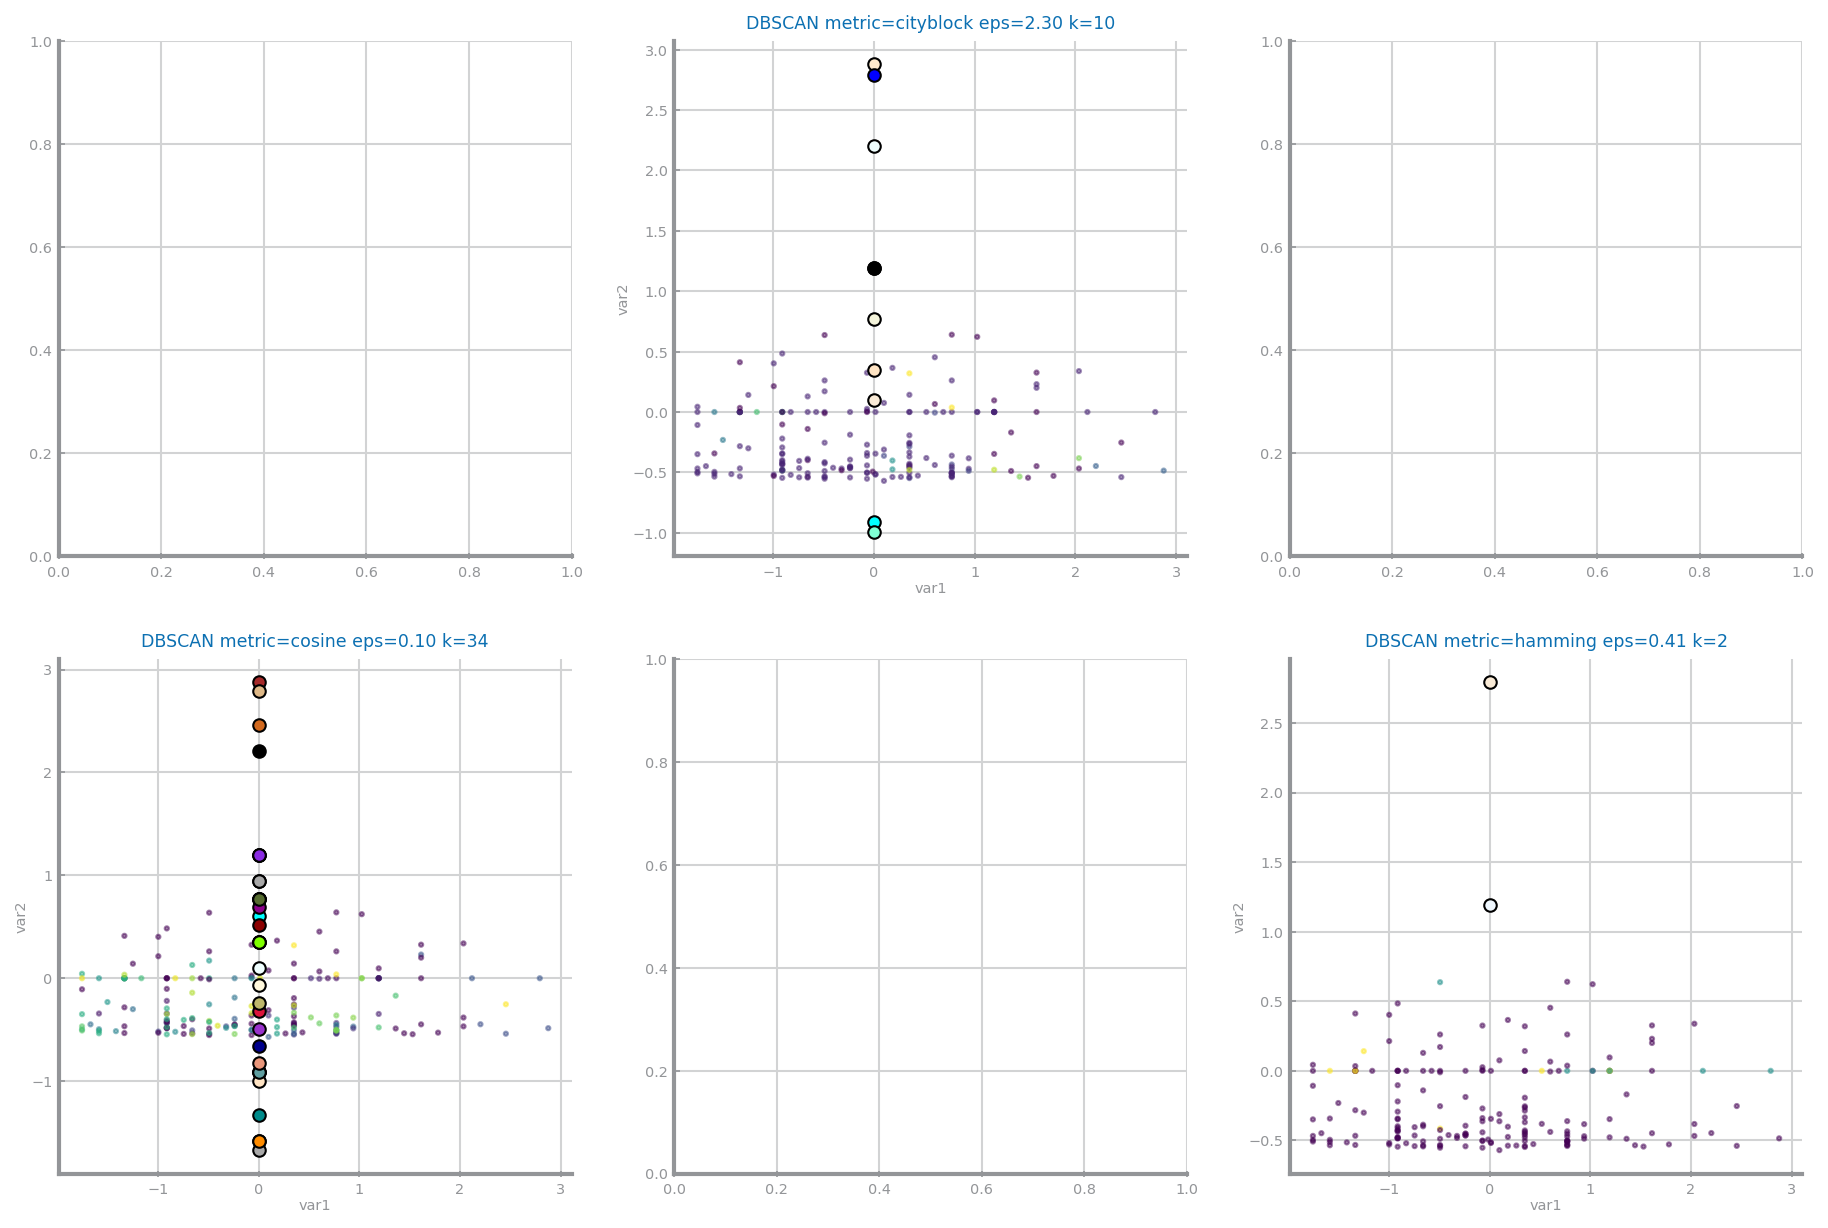

In [18]:
mse: list = []
sc: list = []
db: list = []

rows, cols = ds.choose_grid(len(METRICS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(METRICS)):
    if METRICS[n] == "gower":
        estimator = DBSCAN(eps=distances[n], min_samples=2, metric=gower)
    else:
        estimator = DBSCAN(eps=distances[n], min_samples=2, metric=METRICS[n])
    print("metric {}".format(METRICS[n]))
    estimator.fit(data)
    labels = estimator.labels_
    print("labels: ", labels)
    k = len(set(labels)) - (1 if -1 in labels else 0)
    print("We got k={}".format(k))
    if k > 1:
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        db.append(davies_bouldin_score(data, labels))

        
        ds.plot_clusters(data, 1, 2, labels.astype(float), estimator.components_, k,
                         f'DBSCAN metric={METRICS[n]} eps={distances[n]:.2f} k={k}', ax=axs[i,j])
    else:
        mse.append(0)
        sc.append(0)
        db.append(0)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

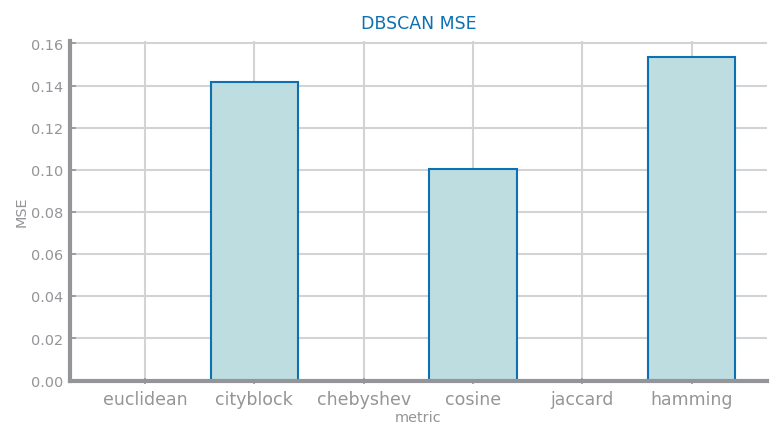

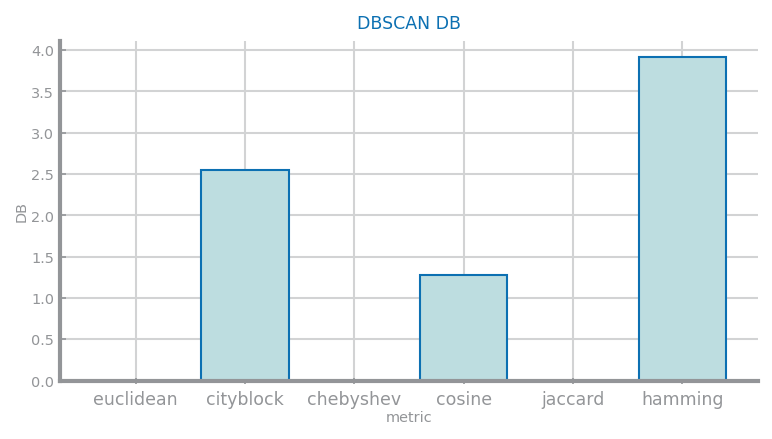

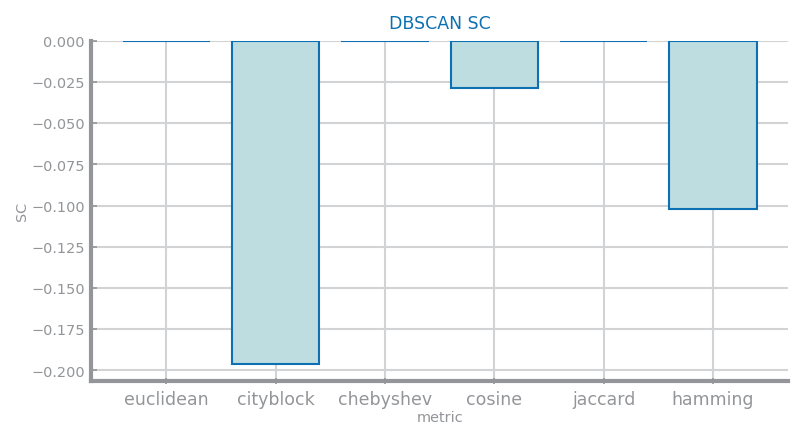

[0, -0.1963158297456517, 0, -0.02891720729501081, 0, -0.10181637790779834]


In [19]:
fig = plt.figure(figsize=(6,3))
ds.bar_chart(METRICS, mse, title='DBSCAN MSE', xlabel='metric', ylabel='MSE')
plt.show()

fig = plt.figure(figsize=(6,3))
ds.bar_chart(METRICS, db, title='DBSCAN DB', xlabel='metric', ylabel='DB')
plt.show()

fig = plt.figure(figsize=(6,3))
ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC')
plt.show()
print(sc)


#fig, ax = plt.subplots(1, 2, figsize=(8, 3), squeeze=False)
#ds.bar_chart(METRICS, db, title='DBSCAN DB', xlabel='metric', ylabel='DB', ax=ax[0, 0])
#ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], percentage=True)
#plt.show()

## Heart Failure Prediction Dataset - Standardized + Importance + FG + Outlier
### After PCA

In [20]:
data: pd.DataFrame = pd.read_csv('../../datasets/pca_output/hf/most_relevant/HR_S_FImp_extra_outlierTrim_IQS_pca.csv')
data.pop('DEATH_EVENT') #Remove target variable

EPS = [0.1, 0.2, 0.35, 0.5, 0.6, 0.75, 0.8, 0.9, 1, 1.5, 2.5]
rows, cols = ds.choose_grid(len(EPS))

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -

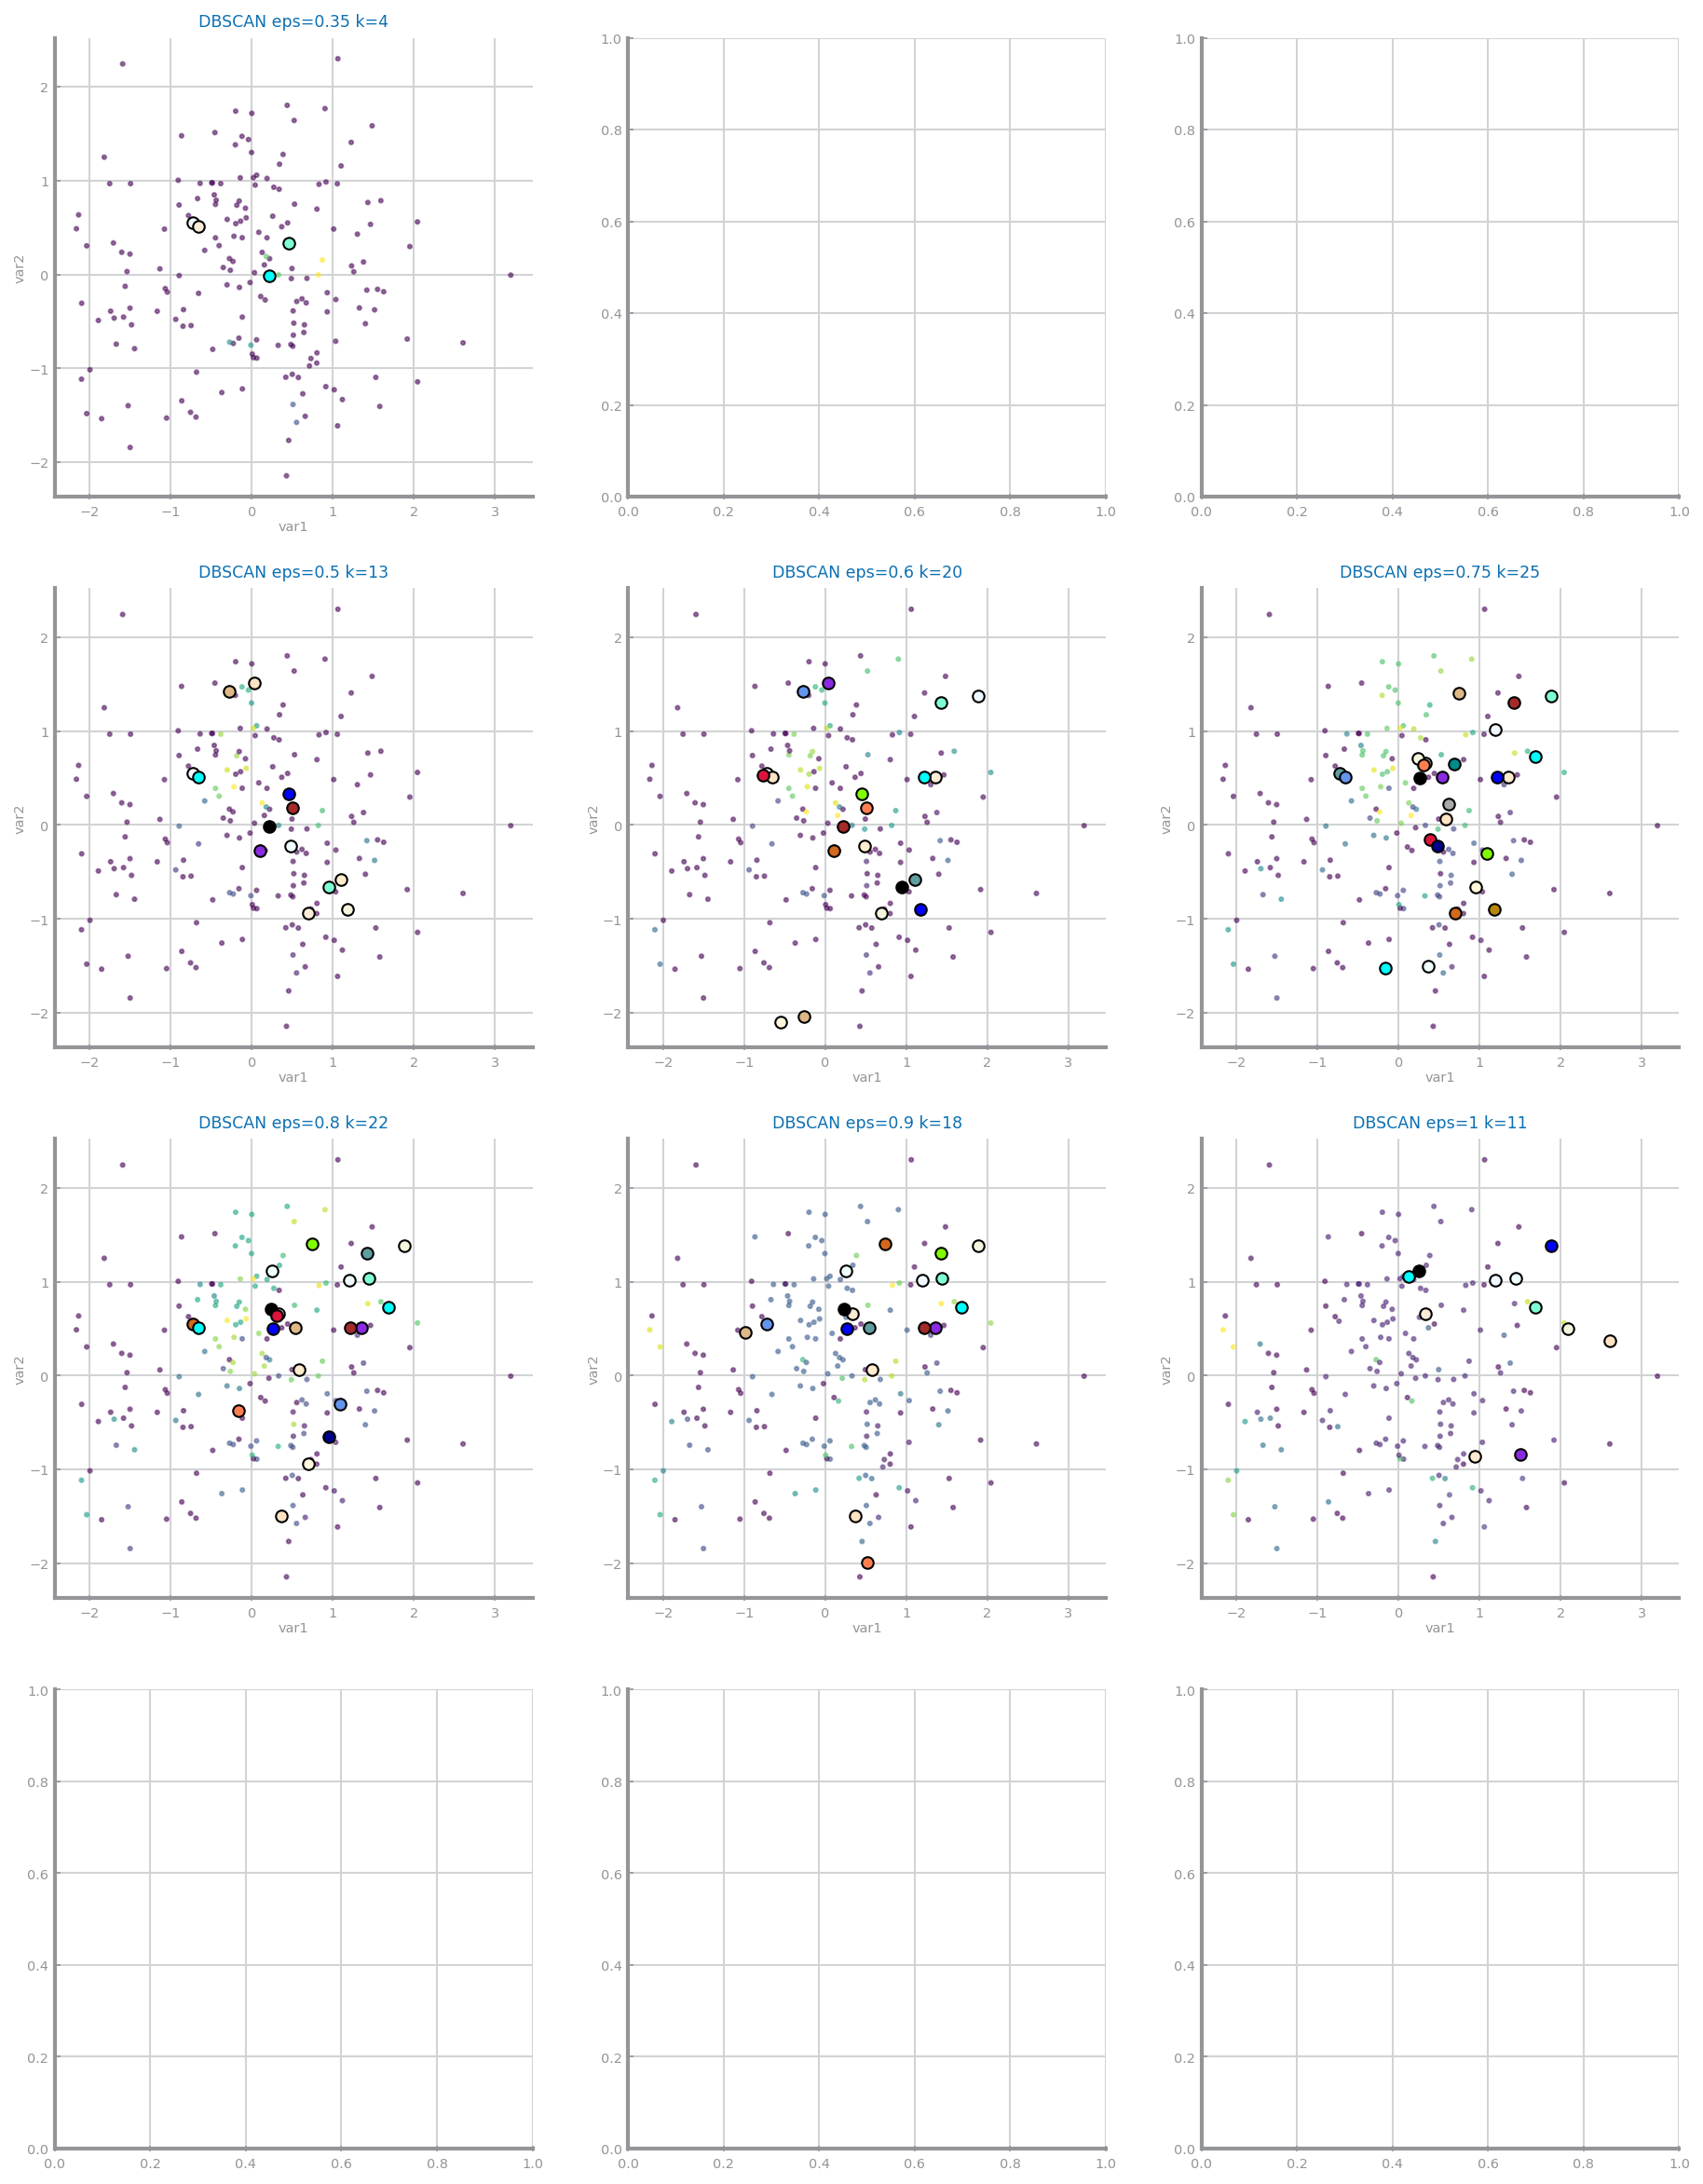

In [21]:
mse: list = []
sc: list = []
db: list = []

_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(EPS)):
    estimator = DBSCAN(eps=EPS[n], min_samples=2)
    estimator.fit(data)
    labels = estimator.labels_
    print(labels)
    k = len(set(labels)) - (1 if -1 in labels else 0)
    if k > 1:
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        db.append(davies_bouldin_score(data, labels))
        
        print("EPS - " + str(EPS[n]))


        ds.plot_clusters(data, 1, 2, labels.astype(float), estimator.components_, k,
                         f'DBSCAN eps={EPS[n]} k={k}', ax=axs[i,j])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    else:
        mse.append(0)
        sc.append(0)
        db.append(0)
plt.show()

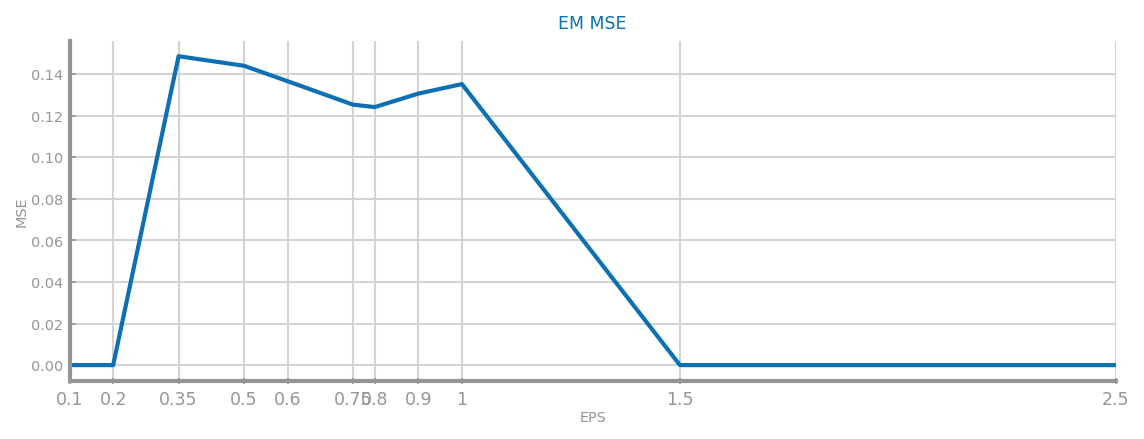

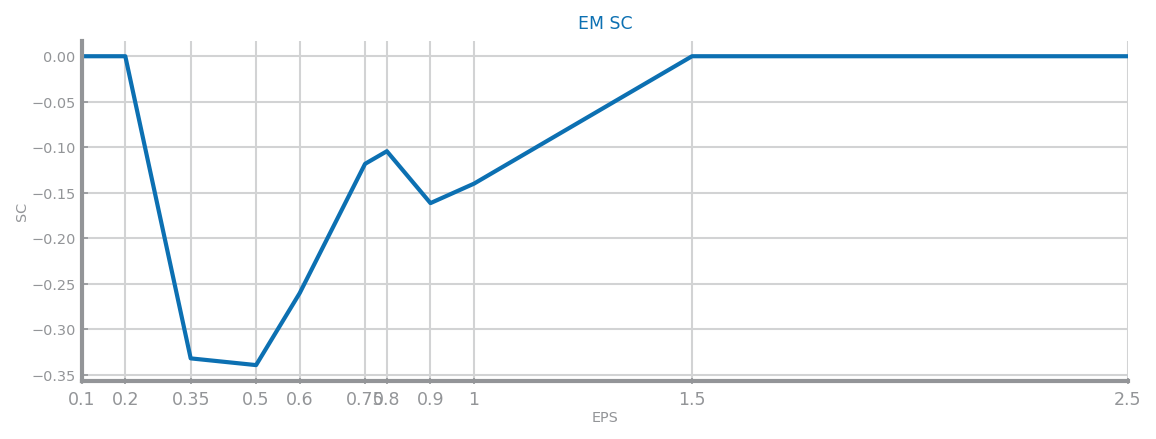

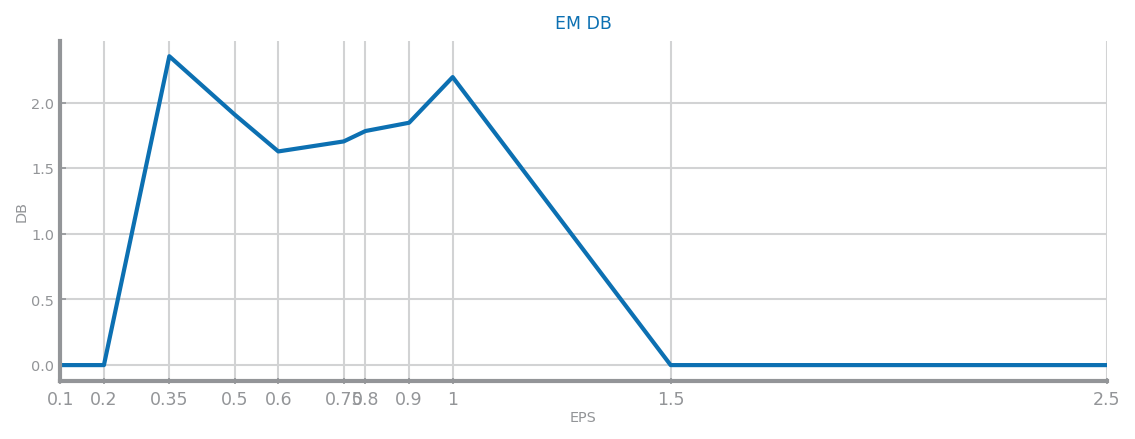

In [22]:
fig = plt.figure(figsize=(9,3))
ds.plot_line(EPS, mse, title='EM MSE', xlabel='EPS', ylabel='MSE')
plt.show()

fig = plt.figure(figsize=(9,3))
ds.plot_line(EPS, sc, title='EM SC', xlabel='EPS', ylabel='SC')
plt.show()

fig = plt.figure(figsize=(9,3))
ds.plot_line(EPS, db, title='EM DB', xlabel='EPS', ylabel='DB')
plt.show()

#fig, ax = plt.subplots(1, 2, figsize=(9, 3), squeeze=False)
#ds.plot_line(EPS, sc, title='EM SC', xlabel='EPS', ylabel='SC', ax=ax[0, 0])
#ds.plot_line(EPS, db, title='EM DB', xlabel='EPS', ylabel='DB', ax=ax[0, 1])
#plt.show()

#### For gower

In [23]:
#It's necessary to obtain the columns dtypes
dtypes = data.dtypes

#It's necessary to normalize between 0 and 1
Xn=normalize_mixed_data_columns(data,dtypes)
print(Xn)
#It's necessary to obtain the range (max-min) values of each numeric column
ranges=calc_range_mixed_data_columns(Xn,dtypes)

[[ 8.21148735e-01  4.58522566e-01  2.32198171e-01  3.49632319e-01
   3.00159910e-01]
 [ 6.57461090e-01  6.10267014e-01  1.29267456e-01  4.70660764e-01
  -3.23719205e-01]
 [ 2.67254193e-01  6.40279420e-01 -4.97763296e-01  2.96488351e-02
  -1.06878145e-01]
 [ 7.98456660e-01  4.85727110e-01 -6.90203423e-02 -3.45438264e-01
  -3.91609779e-01]
 [ 2.75109716e-01 -5.79694683e-01 -6.68500500e-01  4.82746520e-01
  -9.87583270e-02]
 [ 3.86138611e-01  3.18426953e-01 -5.34520155e-01 -2.33593319e-01
   1.33238255e-01]
 [ 1.16460145e-01  4.94227236e-01 -6.11791931e-01  1.77997543e-01
  -6.17332622e-01]
 [ 1.07363352e-01  2.06339195e-01 -6.57492819e-01  3.20808857e-01
   8.38254222e-02]
 [ 3.95853717e-02  3.31369399e-01 -7.01741963e-01  2.13990649e-01
   9.42673122e-01]
 [ 7.99687312e-01 -2.65535955e-01 -2.40074135e-01 -2.97269591e-01
   2.12721428e-01]
 [ 2.78869741e-01  1.00000000e+00 -3.21690936e-03  7.28514690e-01
  -3.80378612e-01]
 [ 5.42690422e-01  2.28460129e-01 -3.89516278e-01 -3.30386644e-01

### Different metrics

In [24]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard', 'hamming'] #, 'gower']
distances = []
for m in METRICS:
    if m == "gower":
        #Add gower
        dist = np.mean(np.mean(squareform(pdist_(Xn, gower,V=ranges,VI=dtypes))))
        distances.append(dist)
        pass
    else:
        dist = np.mean(np.mean(squareform(pdist(data.values, metric=m))))
        distances.append(dist)

print('AVG distances among records', distances)
distances[0] *= 0.5
distances[1] *= 0.4
distances[2] *= 0.1
distances[3] *= 0.1
distances[4] *= 1
distances[5] *= 1
#distances[6] *= 0.5

print('CHOSEN EPS', distances)


AVG distances among records [2.74586877233271, 5.076627490607138, 2.06797330878747, 0.9993130267085124, 0.9946808510638298, 0.9946808510638298]
CHOSEN EPS [1.372934386166355, 2.0306509962428554, 0.20679733087874702, 0.09993130267085125, 0.9946808510638298, 0.9946808510638298]


metric euclidean
labels:  [ 0 -1  0  0  0  0  0  0  0  0 -1  0  0 -1  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
We got k=1
metric cityblock
labels:  [ 0 -1  0 -1  0  0 -1  0  0 -1 -1  0  0 -1  0 -1 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0
  0  0  0  0  1  0  0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1  0  0  0  0 -1  1  0  0  0  0 -1  0  0 -1  0  0  0 -1  0  0 -1

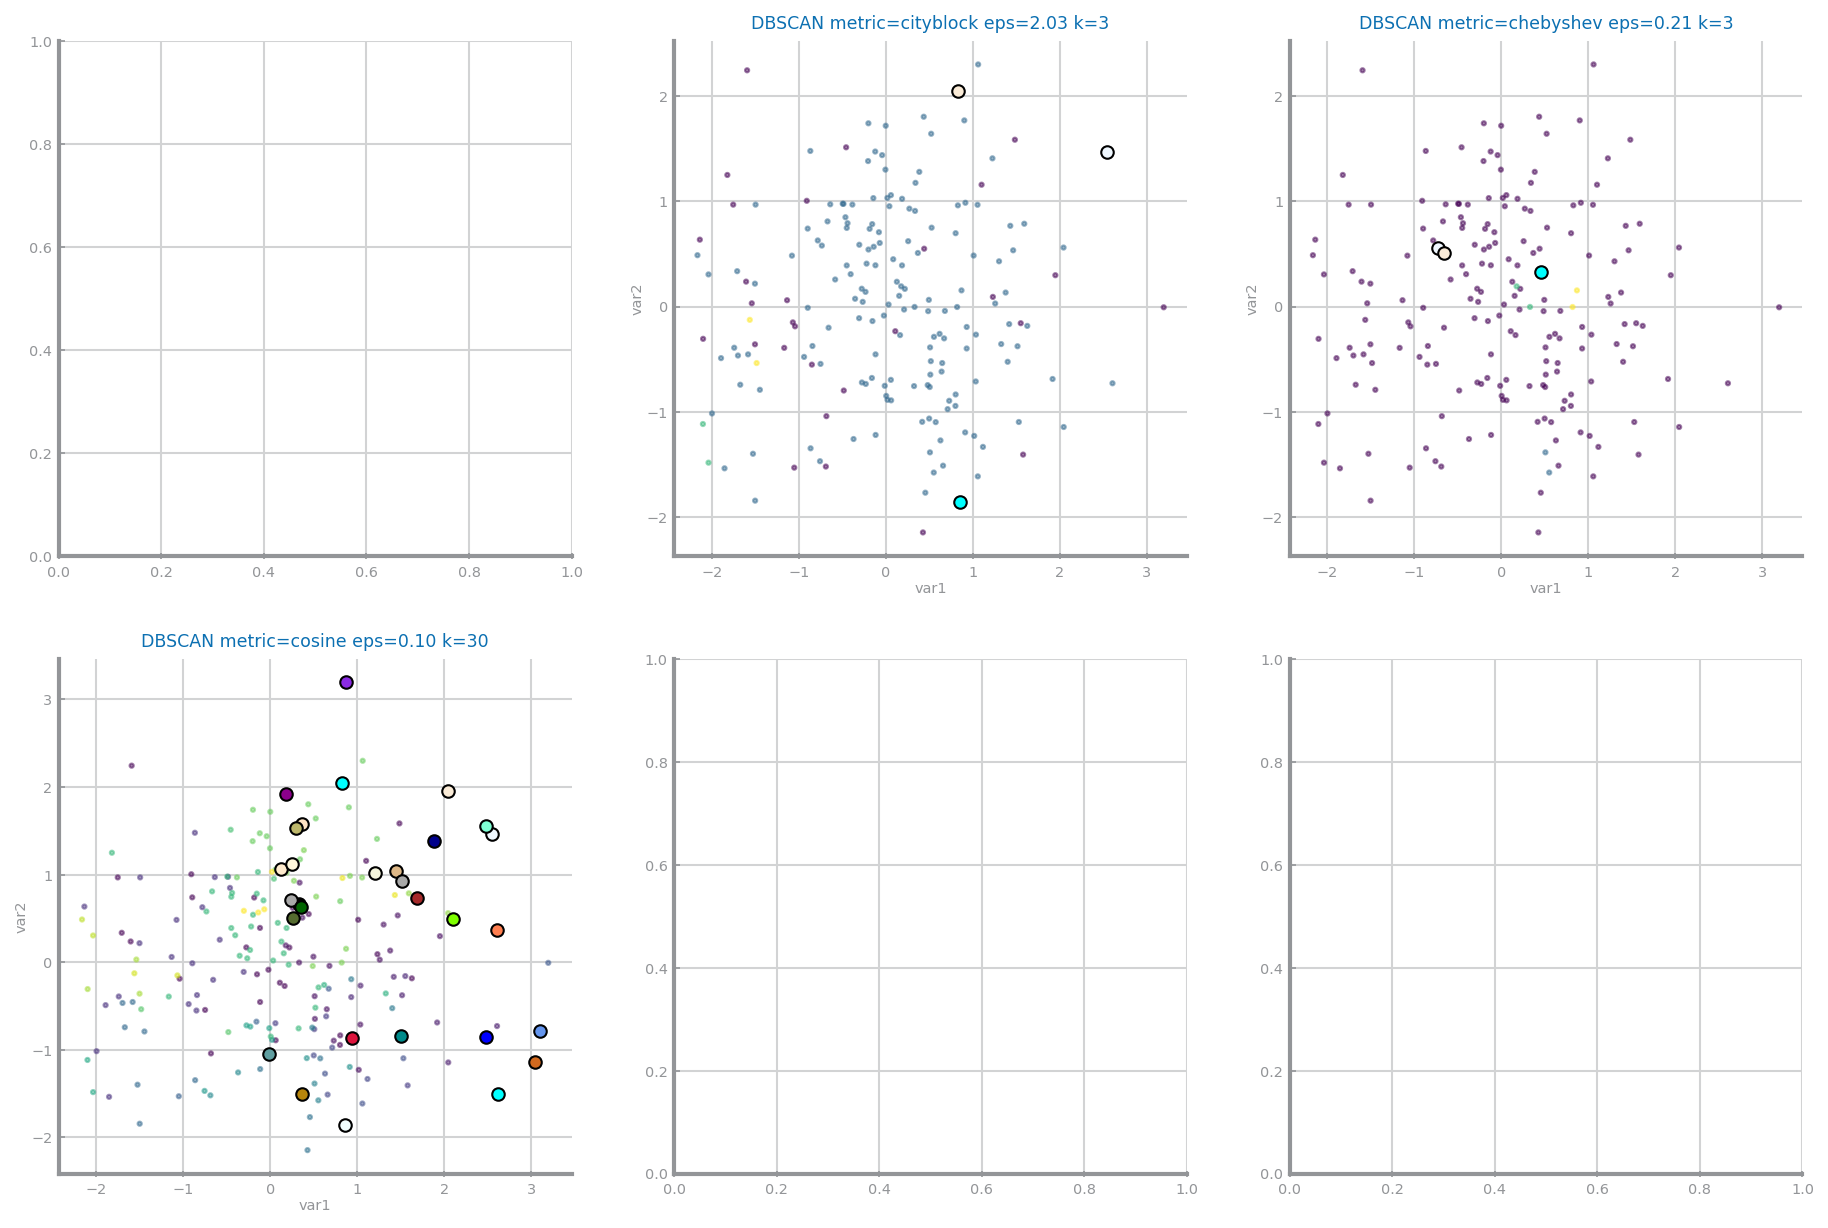

In [25]:
mse: list = []
sc: list = []
db: list = []

rows, cols = ds.choose_grid(len(METRICS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(METRICS)):
    if METRICS[n] == "gower":
        estimator = DBSCAN(eps=distances[n], min_samples=2, metric=gower)
    else:
        estimator = DBSCAN(eps=distances[n], min_samples=2, metric=METRICS[n])
    print("metric {}".format(METRICS[n]))
    estimator.fit(data)
    labels = estimator.labels_
    print("labels: ", labels)
    k = len(set(labels)) - (1 if -1 in labels else 0)
    print("We got k={}".format(k))
    if k > 1:
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        db.append(davies_bouldin_score(data, labels))

        
        ds.plot_clusters(data, 1, 2, labels.astype(float), estimator.components_, k,
                         f'DBSCAN metric={METRICS[n]} eps={distances[n]:.2f} k={k}', ax=axs[i,j])
    else:
        mse.append(0)
        sc.append(0)
        db.append(0)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

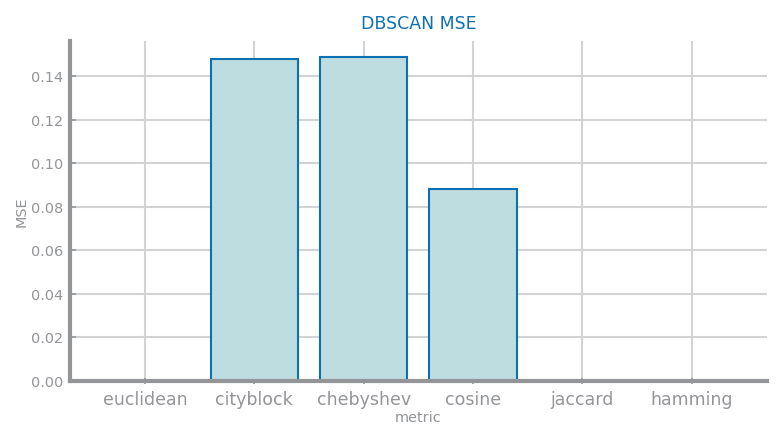

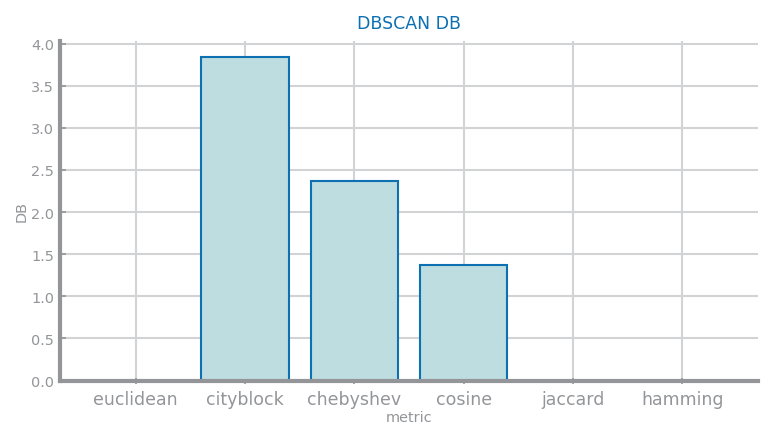

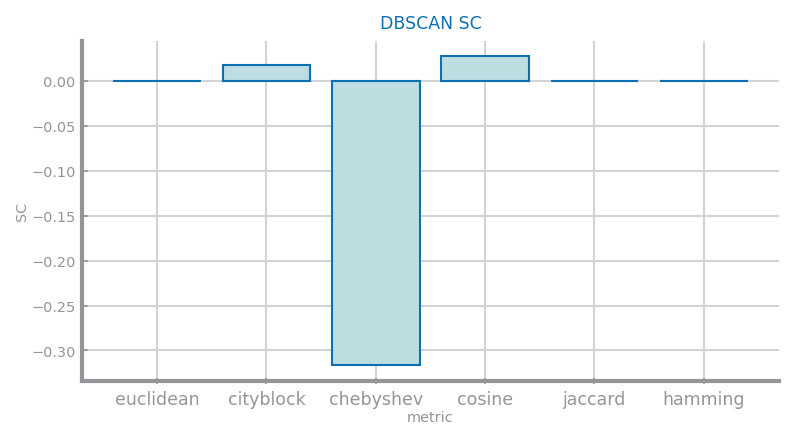

[0, 0.018191437422281062, -0.3162629337712838, 0.02745419331253771, 0, 0]


In [26]:
fig = plt.figure(figsize=(6,3))
ds.bar_chart(METRICS, mse, title='DBSCAN MSE', xlabel='metric', ylabel='MSE')
plt.show()

fig = plt.figure(figsize=(6,3))
ds.bar_chart(METRICS, db, title='DBSCAN DB', xlabel='metric', ylabel='DB')
plt.show()

fig = plt.figure(figsize=(6,3))
ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC')
plt.show()
print(sc)


#fig, ax = plt.subplots(1, 2, figsize=(8, 3), squeeze=False)
#ds.bar_chart(METRICS, db, title='DBSCAN DB', xlabel='metric', ylabel='DB', ax=ax[0, 0])
#ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], percentage=True)
#plt.show()

## Heart Failure Prediction Dataset - Standardized + Importance + FG + Outlier
### After LDA

In [27]:
data: pd.DataFrame = pd.read_csv('../../datasets/pca_output/hf/most_relevant/HR_S_FImp_extra_outlierTrim_IQS_lda.csv')
data.pop('DEATH_EVENT') #Remove target variable

EPS = [0.1, 0.2, 0.35, 0.5, 0.6, 0.75, 0.8, 0.9, 1, 1.5, 2.5]
rows, cols = ds.choose_grid(len(EPS))

[-1  0  1  1  2  3  3  4  4  3  5  5  5  2  1  0  5  5  1  4  2  4 -1  2
  2  5  4  5  5  2  3  2  2  3  3  3  2  2  2  5  2  2  2  2  3  2  3  2
  2  2  4  2  2  2  5  2  2  2  2  4  2  5  2  2  2  2  3  2  2  5  2  2
  2  2  2  2  2  2  2 -1  2  4  2  2  2  2  2  5  2  2  2  3  2  2  2  2
  2  4  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  2  2  2  2  2  2  6
  2  2  2  2  2  2  6  2  2  2  2  2  3  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  6  2  2  2  7  2  2  2  6  2
  2  2  2  2  2  2  2  7 -1  2  2  6  2  2  2  2 -1  2  2  2]
EPS - 0.1
[-1  0  1  1  2  2  2  2  2  2  2  2  2  2  1  0  2  2  1  2  2  2  1  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 

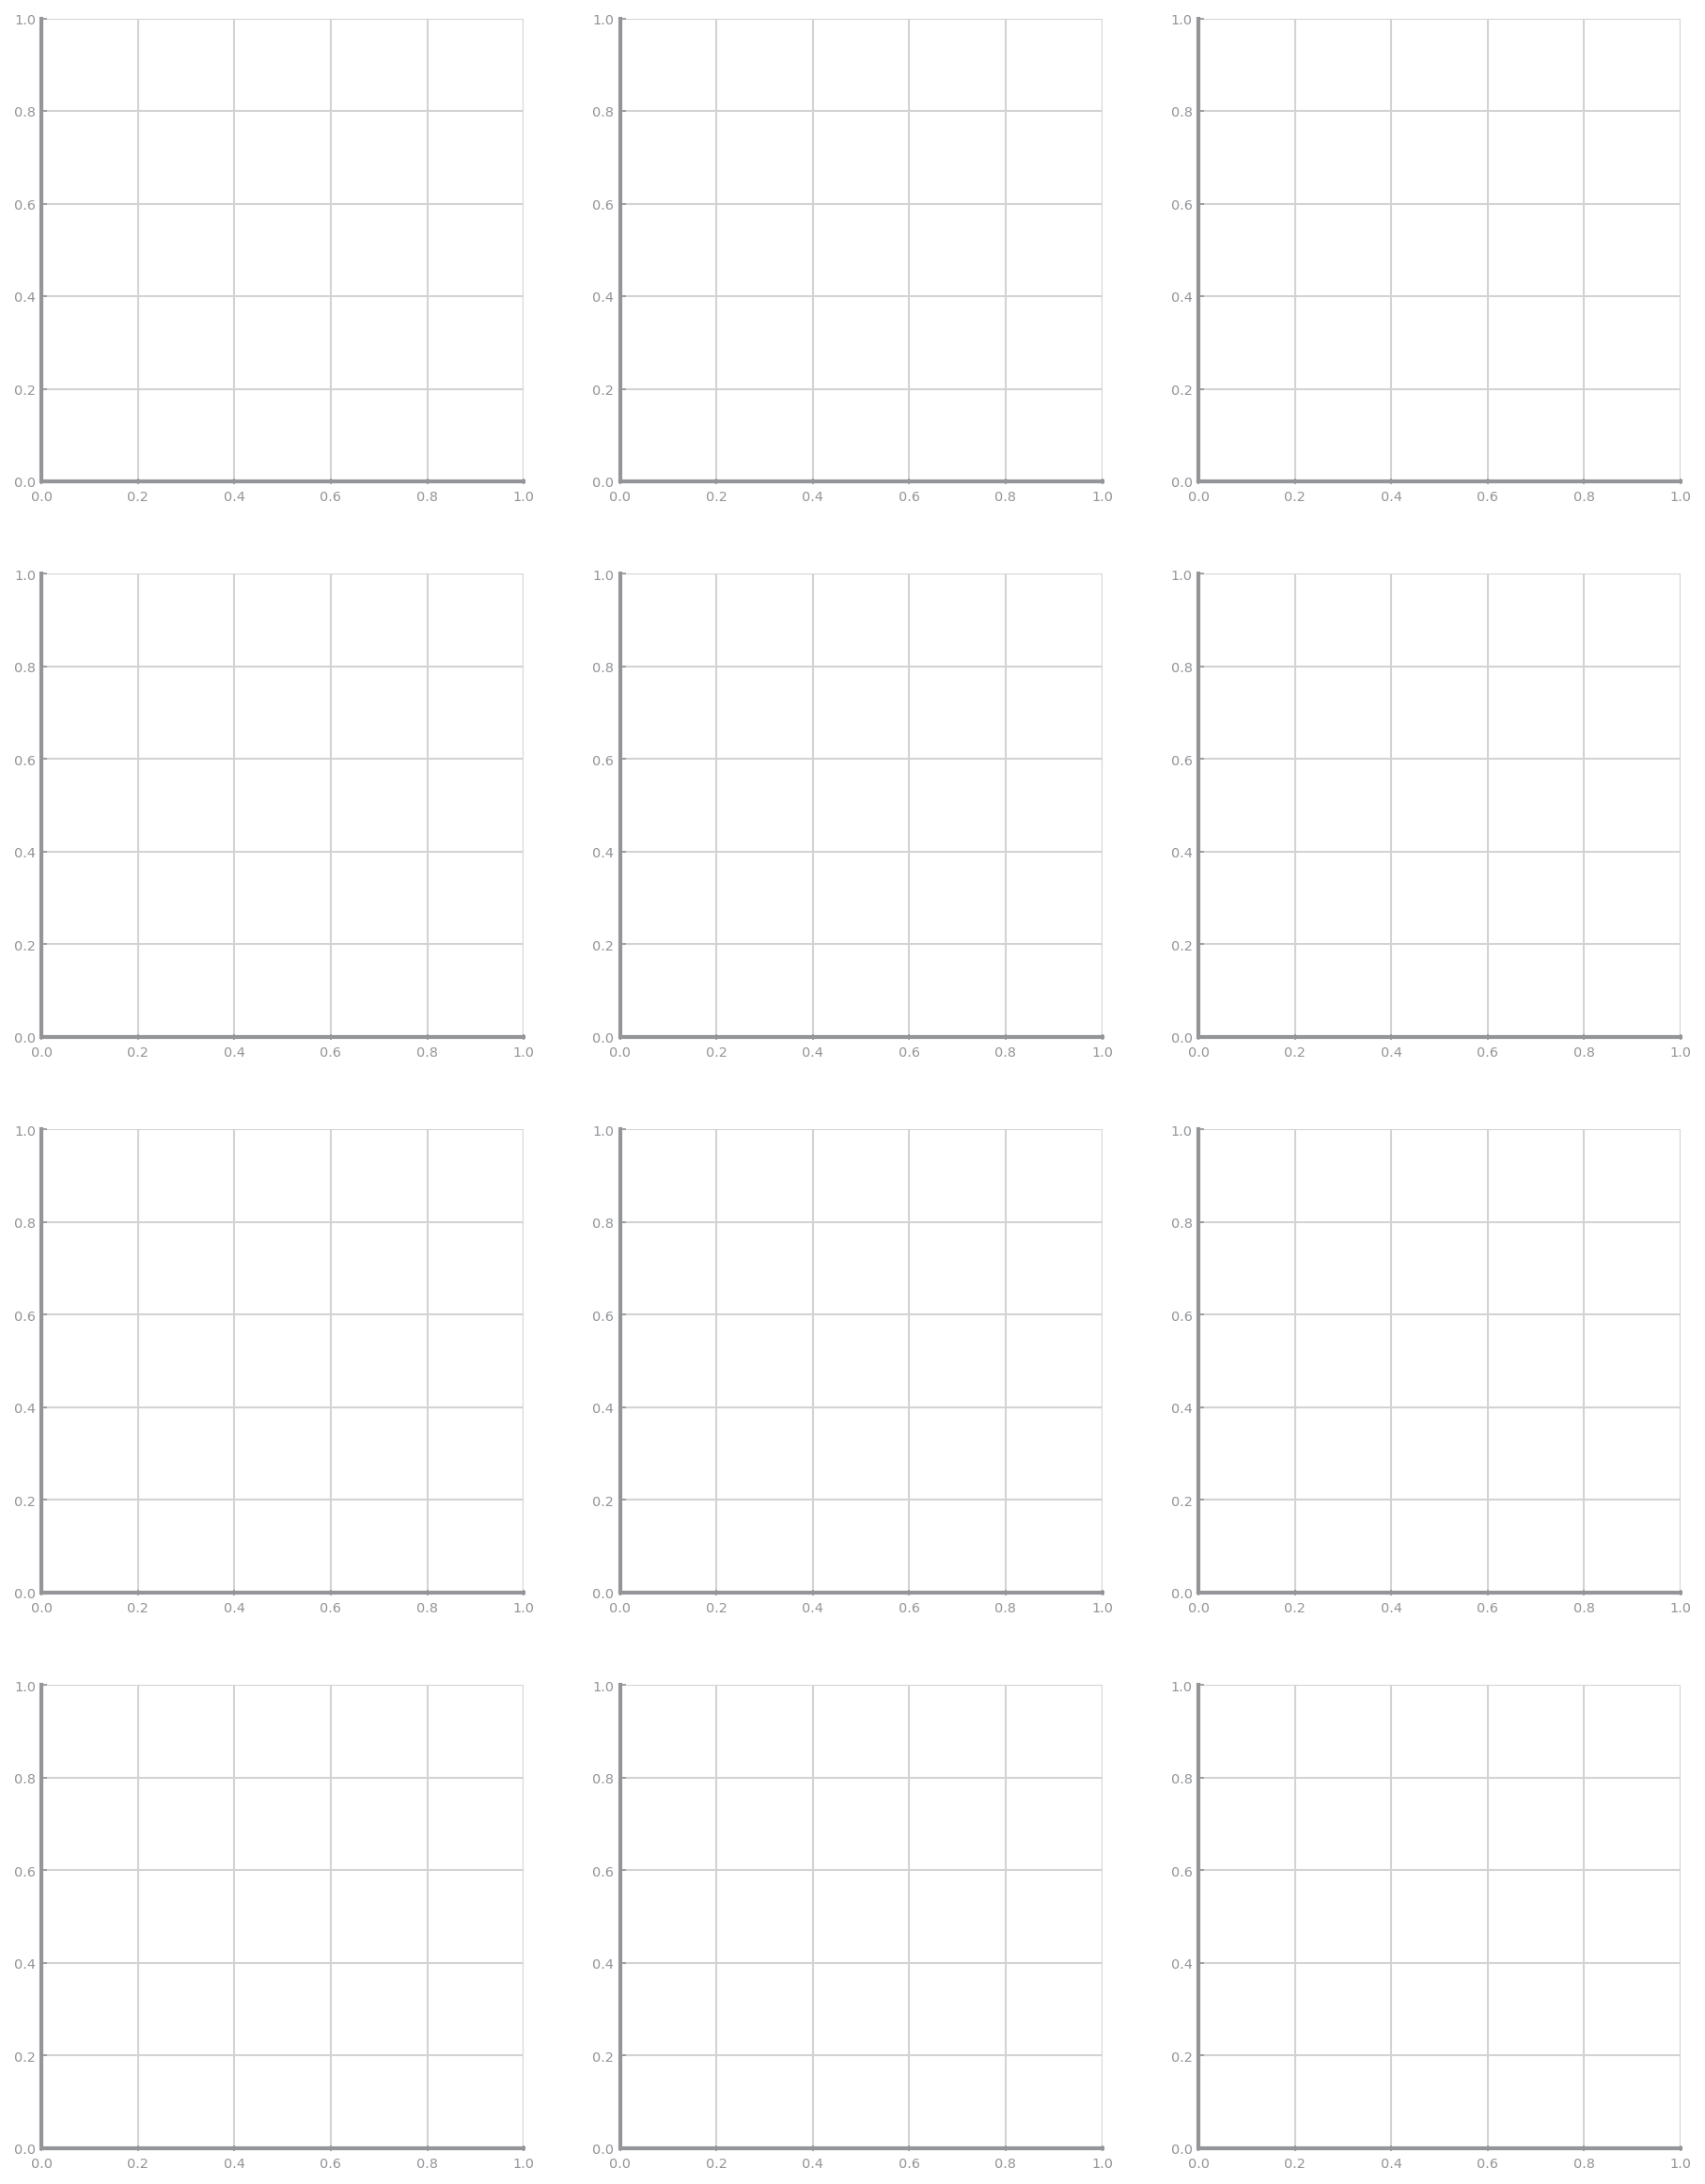

In [28]:
mse: list = []
sc: list = []
db: list = []

_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(EPS)):
    estimator = DBSCAN(eps=EPS[n], min_samples=2)
    estimator.fit(data)
    labels = estimator.labels_
    print(labels)
    k = len(set(labels)) - (1 if -1 in labels else 0)
    if k > 1:
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        db.append(davies_bouldin_score(data, labels))
        
        print("EPS - " + str(EPS[n]))


        #ds.plot_clusters(data, 0, 1, labels.astype(float), estimator.components_, k,
                         #f'DBSCAN eps={EPS[n]} k={k}', ax=axs[i,j])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    else:
        mse.append(0)
        sc.append(0)
        db.append(0)
plt.show()

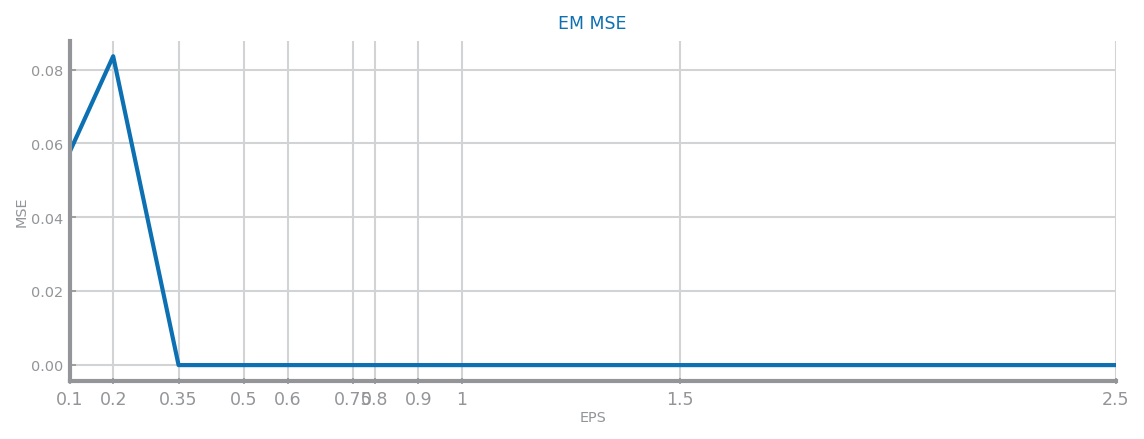

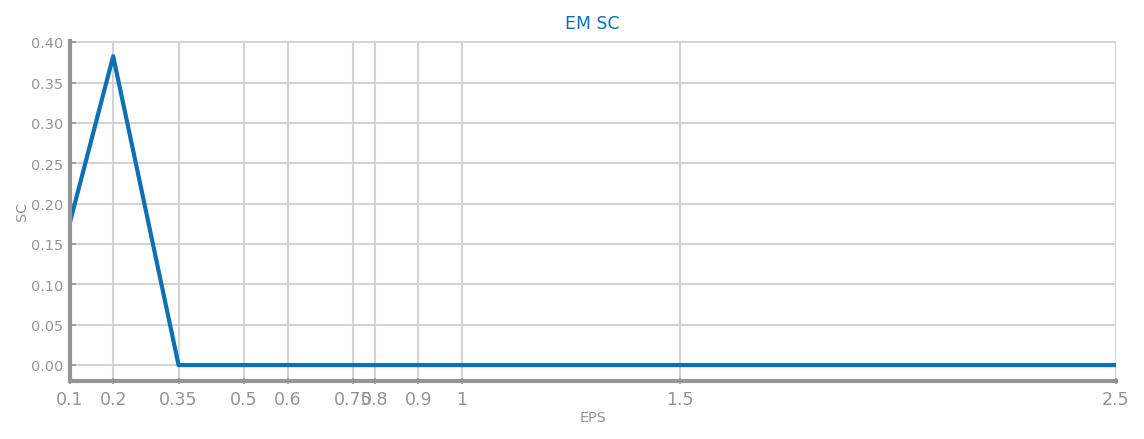

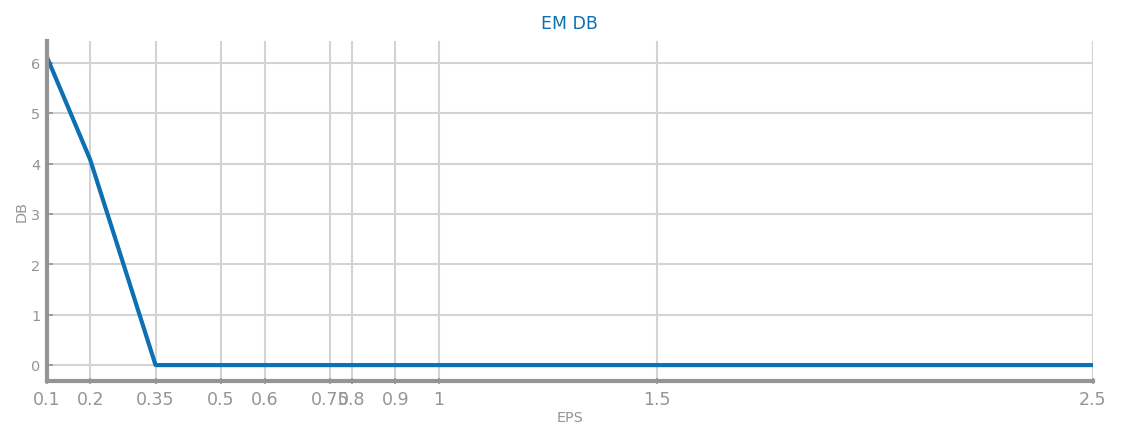

In [29]:
fig = plt.figure(figsize=(9,3))
ds.plot_line(EPS, mse, title='EM MSE', xlabel='EPS', ylabel='MSE')
plt.show()

fig = plt.figure(figsize=(9,3))
ds.plot_line(EPS, sc, title='EM SC', xlabel='EPS', ylabel='SC')
plt.show()

fig = plt.figure(figsize=(9,3))
ds.plot_line(EPS, db, title='EM DB', xlabel='EPS', ylabel='DB')
plt.show()

#fig, ax = plt.subplots(1, 2, figsize=(9, 3), squeeze=False)
#ds.plot_line(EPS, sc, title='EM SC', xlabel='EPS', ylabel='SC', ax=ax[0, 0])
#ds.plot_line(EPS, db, title='EM DB', xlabel='EPS', ylabel='DB', ax=ax[0, 1])
#plt.show()

In [30]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard', 'hamming'] #, 'gower']
distances = []
for m in METRICS:
    if m == "gower":
        #Add gower
        dist = np.mean(np.mean(squareform(pdist_(Xn, gower,V=ranges,VI=dtypes))))
        distances.append(dist)
        pass
    else:
        dist = np.mean(np.mean(squareform(pdist(data.values, metric=m))))
        distances.append(dist)

print('AVG distances among records', distances)
distances[0] *= 0.15
distances[1] *= 0.1
distances[2] *= 0.1
distances[3] *= 0.1
distances[4] *= 1
distances[5] *= 1
#distances[6] *= 0.5

print('CHOSEN EPS', distances)


AVG distances among records [1.4571799523541729, 1.4571799523541729, 1.4571799523541729, 0.9944545043005885, 0.9946808510638298, 0.9946808510638298]
CHOSEN EPS [0.21857699285312593, 0.14571799523541729, 0.14571799523541729, 0.09944545043005885, 0.9946808510638298, 0.9946808510638298]


metric euclidean
labels:  [-1  0  0  0  1  1  1  1  1  1  1  1  1  1  0  0  1  1  0  1  1  1  0  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
We got k=2
metric cityblock
labels:  [-1  0  1  1  2  2  2  2  2  2  2  2  2  2  1  0  2  2  1  2  2  2  1  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  0  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2

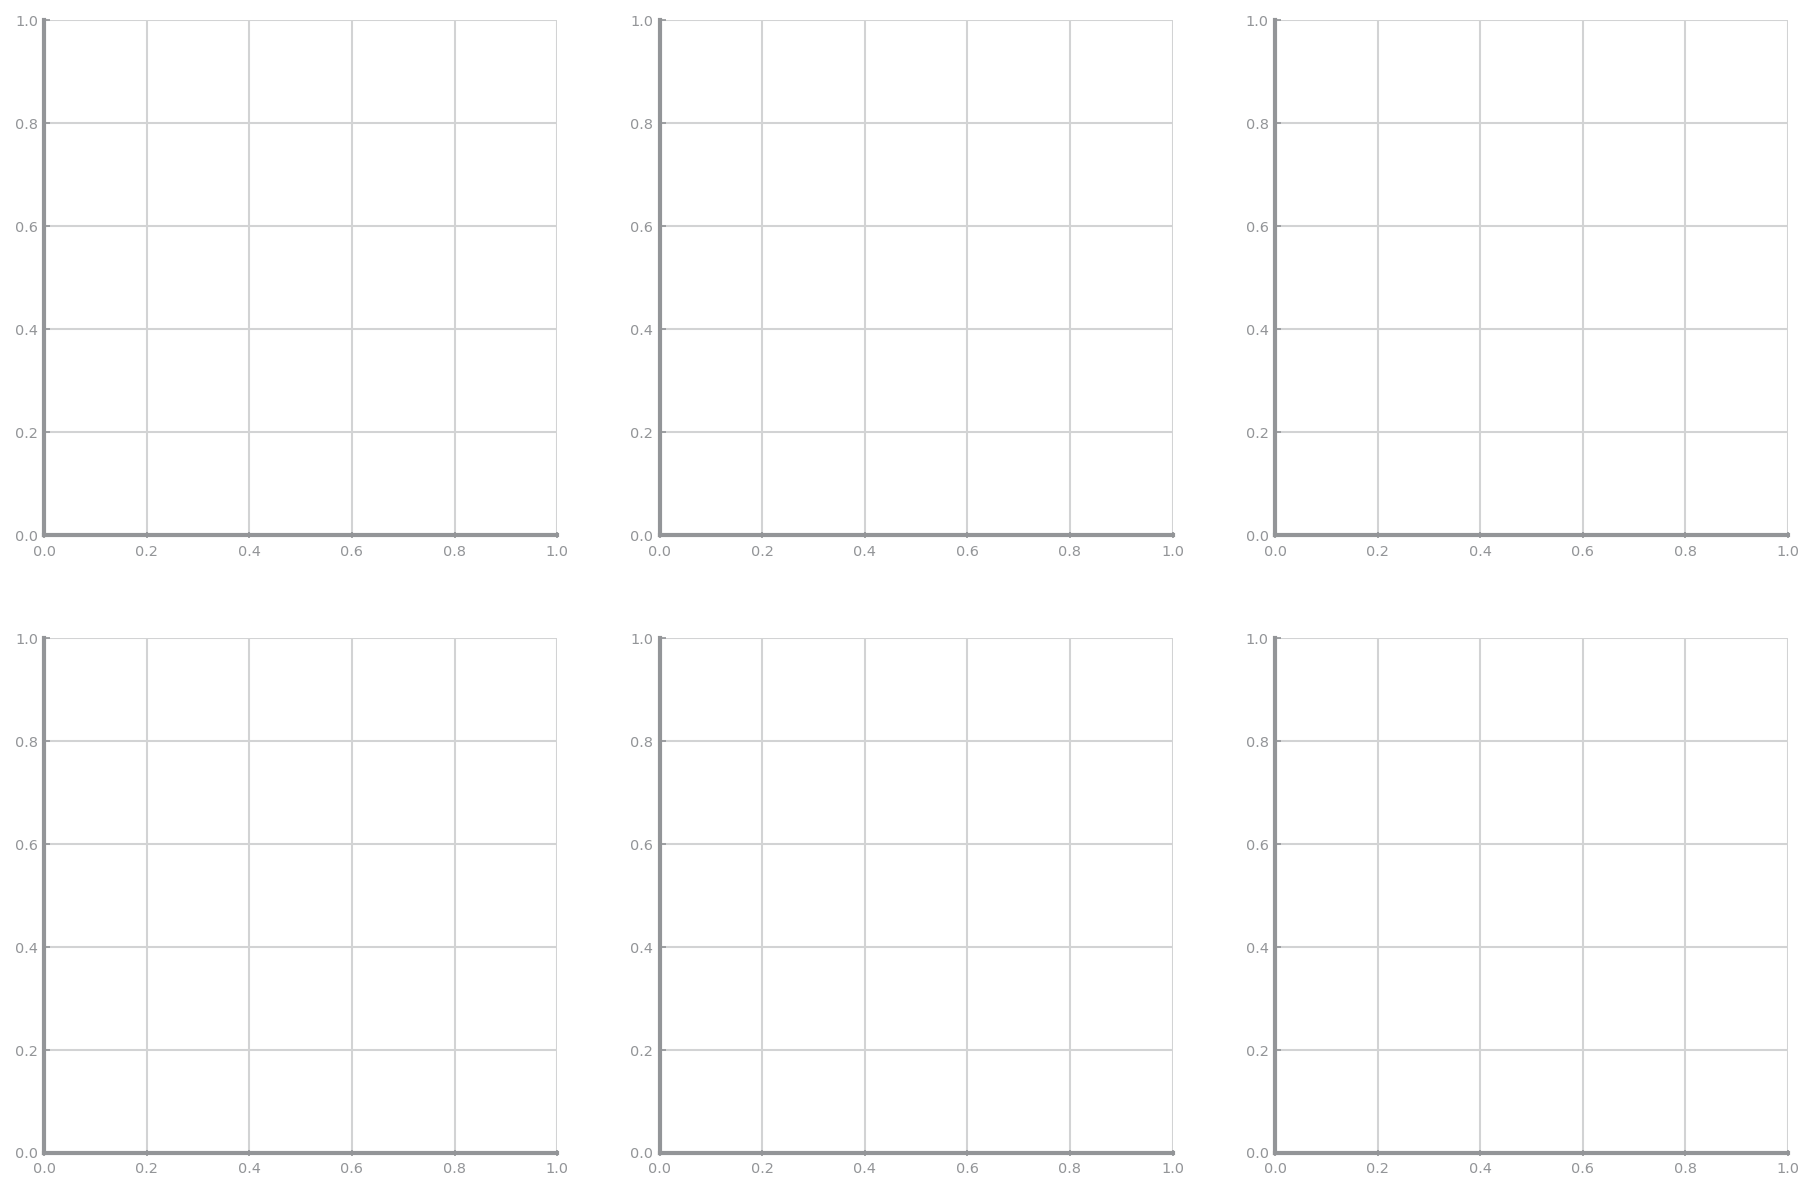

In [31]:
mse: list = []
sc: list = []
db: list = []

rows, cols = ds.choose_grid(len(METRICS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(METRICS)):
    if METRICS[n] == "gower":
        estimator = DBSCAN(eps=distances[n], min_samples=2, metric=gower)
    else:
        estimator = DBSCAN(eps=distances[n], min_samples=2, metric=METRICS[n])
    print("metric {}".format(METRICS[n]))
    estimator.fit(data)
    labels = estimator.labels_
    print("labels: ", labels)
    k = len(set(labels)) - (1 if -1 in labels else 0)
    print("We got k={}".format(k))
    if k > 1:
        centers = ds.compute_centroids(data, labels)
        mse.append(ds.compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        db.append(davies_bouldin_score(data, labels))

        
        #ds.plot_clusters(data, 1, 2, labels.astype(float), estimator.components_, k,
                         #f'DBSCAN metric={METRICS[n]} eps={distances[n]:.2f} k={k}', ax=axs[i,j])
    else:
        mse.append(0)
        sc.append(0)
        db.append(0)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

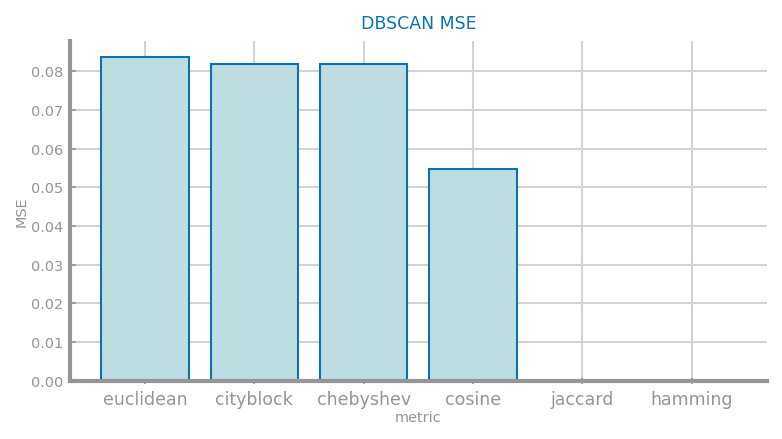

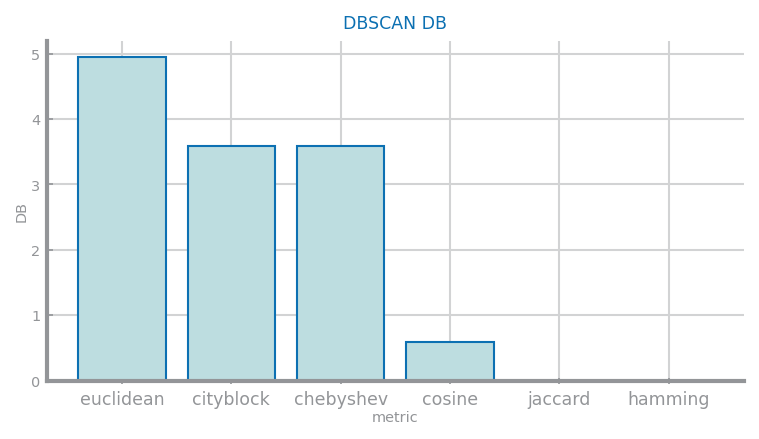

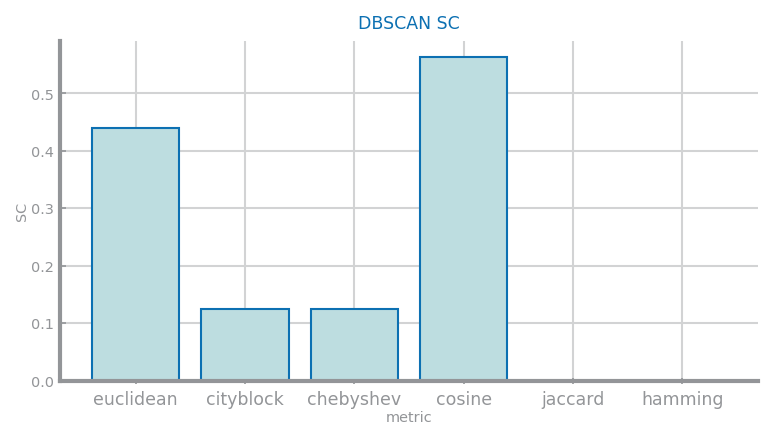

[0.43916359157102586, 0.12400627788631488, 0.12400627788631488, 0.5635167850893547, 0, 0]


In [32]:
fig = plt.figure(figsize=(6,3))
ds.bar_chart(METRICS, mse, title='DBSCAN MSE', xlabel='metric', ylabel='MSE')
plt.show()

fig = plt.figure(figsize=(6,3))
ds.bar_chart(METRICS, db, title='DBSCAN DB', xlabel='metric', ylabel='DB')
plt.show()

fig = plt.figure(figsize=(6,3))
ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC')
plt.show()
print(sc)


#fig, ax = plt.subplots(1, 2, figsize=(8, 3), squeeze=False)
#ds.bar_chart(METRICS, db, title='DBSCAN DB', xlabel='metric', ylabel='DB', ax=ax[0, 0])
#ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], percentage=True)
#plt.show()